In [2]:
import cv2
import numpy as np
from google.colab import drive
import matplotlib.pylab as plt
from google.colab.patches import cv2_imshow
import math
import copy

#A
import random
import cv2
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from google.colab import drive
from google.colab.patches import cv2_imshow
from skimage.filters import threshold_local
from skimage import io
from skimage.transform import rotate
from skimage.color import rgb2gray
import imutils
from typing import Tuple, Union
import math
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


(1908, 4032, 3)
Deteccion de bordes


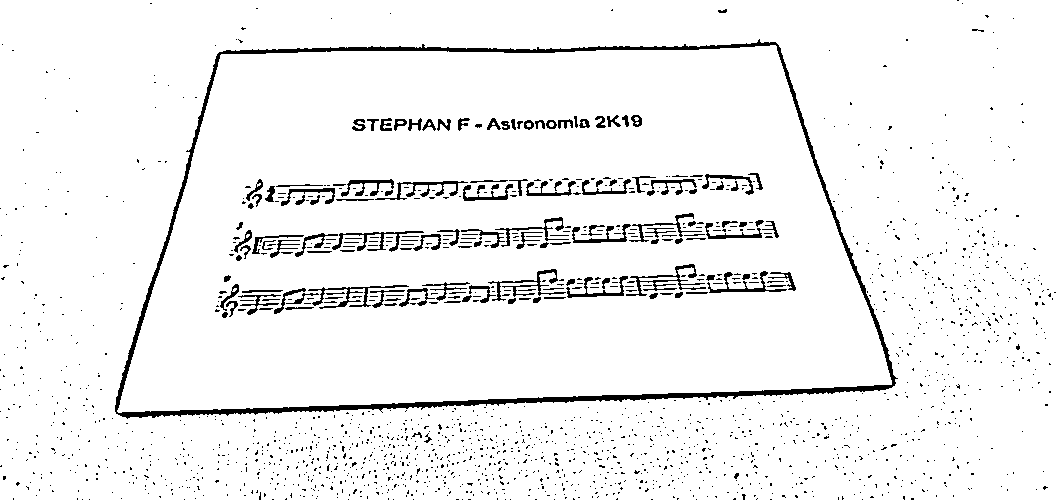

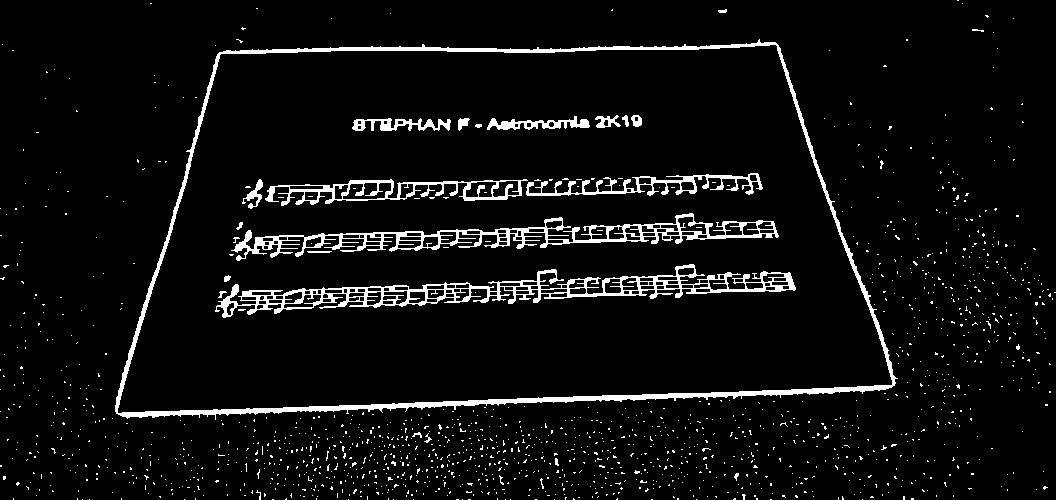

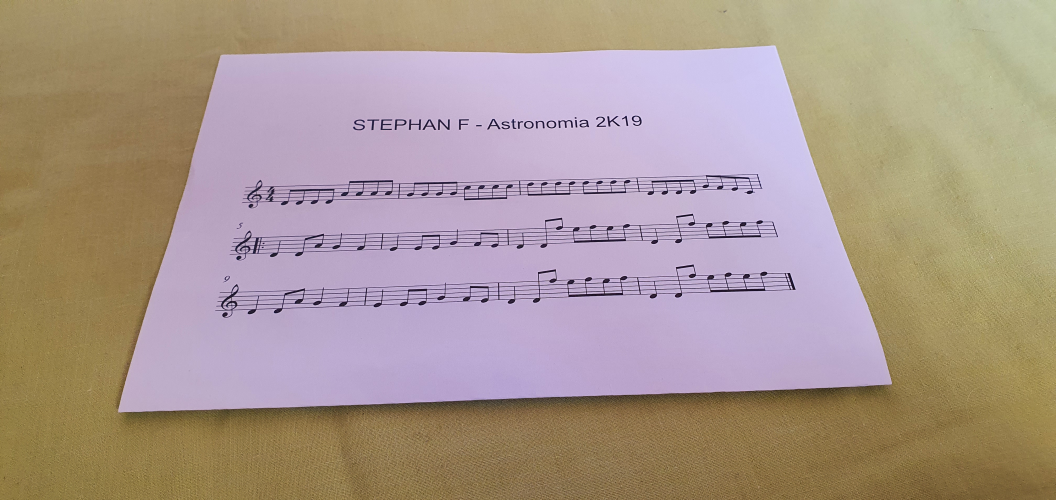

In [11]:
# Cargar imagen, redimensionar
im = '/content/drive/My Drive/tf/Pruebas/fotos/fotoastronomia2.jpg'
notas =  '/content/drive/My Drive/tf/Notas/'
image = cv2.imread(im)
# Redimensionamos la imagen para agilizar el procesamiento
# La proporción 'ratio' servirá para la transformacion de perspectiva
ratio = image.shape[0] / 500.0
#print(image.shape[0])
#print(ratio)
print(image.shape)
imagen_original = image.copy()
image = imutils.resize(image, height = 500)

# convertir a escala de grises, aplicar difuminasión gaussiana y encontrar borde en la imagen
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#gray = cv2.blur(gray,(5,5))
gray = cv2.GaussianBlur(gray, (5, 5), 0)
gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,13,3)
edged = cv2.Canny(gray, 75, 200)

# Mostrar imagen original redimensionada y la imagen procesada para encontrar bordes
print("Deteccion de bordes")
#cv2_imshow(image)
cv2_imshow(gray)
ha,wa = gray.shape
gray = cv2.bitwise_not(gray)
kernel = np.ones((int(wa*0.001),1),np.uint8)
gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
kernel = np.ones((1,int(ha*0.001)),np.uint8)
gray= cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)


#gray = cv2.bitwise_not(gray)
cv2_imshow(gray)
cv2_imshow(image)

#Procesamiento del Fondo

[[[897 378]]

 [[775  42]]

 [[226  50]]

 [[115 411]]]
Encontrar los contornos del papel


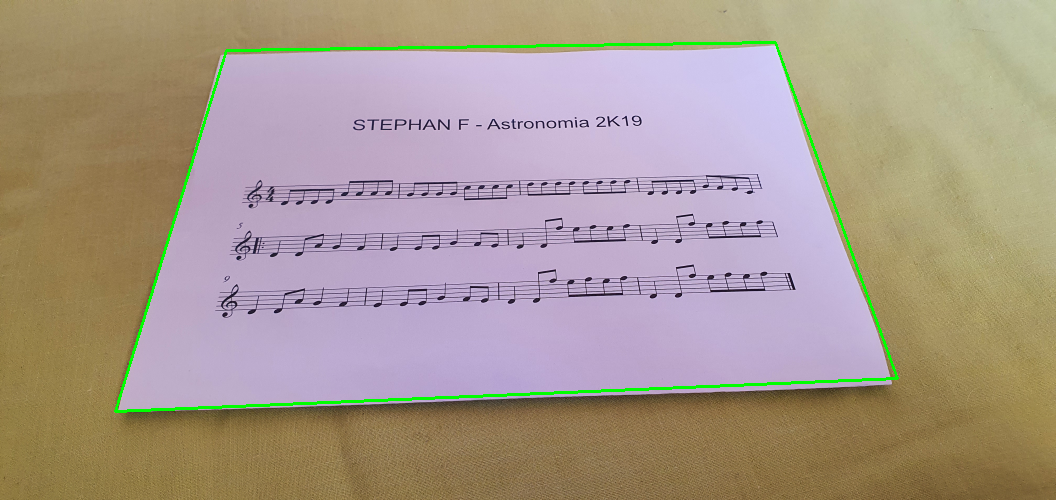

In [12]:
# Encontrar los contornos en la imagen bordeada. Conservar los contornos mas grandes. Definir el contorno de la pantalla
#gray = cv2.bitwise_not(gray)
contornos = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contornos = imutils.grab_contours(contornos)
contornos = sorted(contornos, key = cv2.contourArea, reverse = True)[:5]
#cv2.drawContours(image, contornos, -1, (0, 255, 0), 2)
# Iterar sobre los contornos
for c in contornos:
	# Aproximacion del contorno
  peri = cv2.arcLength(c, True)
  
  approx = cv2.approxPolyDP(c, 0.1*cv2.arcLength(c,True), True)
	# Si encontramos un contorno de cuatro lados entonces encontramos el contorno de la pantalla
  print(approx)

  if len(approx) == 4:
    screenCnt = approx
    break

# show the contour (outline) of the piece of paper
print("Encontrar los contornos del papel")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
cv2_imshow(image)

In [13]:
# Funcion para transformacion de rotacion
def rotate(
        image: np.ndarray, angle: float, background: Union[int, Tuple[int, int, int]]
) -> np.ndarray:
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

def ordenar_puntos(puntos):
  # Inicializar lista de coordenadas en el siguiente orden: esquina superior izquierda, esquina superior derecha,
  # esquina inferior derecha, esquina inferior izquierda.
	rectangulo = np.zeros((4, 2), dtype = "float32")

  # punto superior izquierda tendra la menor suma
	# punto inferior derecho tendra la mayor suma
	s = puntos.sum(axis = 1)
	rectangulo[0] = puntos[np.argmin(s)]
	rectangulo[2] = puntos[np.argmax(s)]

  # encontrar la diferencia entre los puntos.
  # punto superior derecho tendra la menor diferencia
  # punto inferior izquierdo tendra la mayor diferencia
	dif = np.diff(puntos, axis = 1)
	rectangulo[1] = puntos[np.argmin(dif)]
	rectangulo[3] = puntos[np.argmax(dif)]

	# retornar las coordenadas ordenadas
	return rectangulo

def four_point_transform(image, puntos):
  # hallar orden de los puntos del rectangulo
	rectangulo = ordenar_puntos(puntos)
	(top_left, top_right, bottom_right, bottom_left) = rectangulo

  # el ancho de la imagen obtenida sera la distancia maxima entre la coordenada 'x' inferior izquierda y la derecha,
	# o las superiores
	widthA = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
	widthB = np.sqrt(((top_left[0] - top_left[0]) ** 2) + ((top_left[1] - top_left[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

  # la altura de la imagen obtenida sera la distancia maxima entre la coordenada 'y' superior derecha e inferior derecha,
	# o superior izquierda e inferior izquierda
	heightA = np.sqrt(((top_left[0] - bottom_right[0]) ** 2) + ((top_left[1] - bottom_right[1]) ** 2))
	heightB = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

  # Construir un set de puntos destino para lograr una visión ideal de la imagen.
  #
	distancias = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	# Transformacion de perspectiva
	M = cv2.getPerspectiveTransform(rectangulo, distancias)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	# return the warped image
	return warped

# Aplicar transformación a los cuatro puntos del contorno de pantalla seleccionado para cambiar la perspectiva de la imagen original.
warped = four_point_transform(imagen_original, screenCnt.reshape(4, 2) * ratio)

# Convertir la imagen transformada a escala de grises y establecer el umbral para visualizar en blanco y negro
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
#cv2_imshow(warped)
#T = threshold_local(warped, 11, offset = 10, method = "gaussian")
#T = warped
#warped = (warped > T).astype("uint8") * 255

# Mostrar la imagen original y la imagen escaneada
print("Perspectiva")
global angle
global cropped
def GirarMostrar(x):
    global cropped
    angle = x
    print("angulo: ", angle)
    rotated = rotate(warped, angle, (0,0,0))

    #filtro
    # Aplicacion de filtros para que el output no tenga ruido y predominen las areas de color negro
    #rotated = cv2.medianBlur(rotated,5)
    #rotated = cv2.blur(rotated,(4,2))
    #gaussianblur = cv2.GaussianBlur(rotated,(5,5),1)
    #gaussianblur, rotated = cv2.threshold(rotated,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #rotated = cv2.blur(rotated,(4,2))
    #rotated = cv2.blur(rotated,(4,2))
    
    #recortar
    cropped = rotated[30:rotated.shape[0]-40, 30:rotated.shape[1]-40]
    
    #cv2_imshow(imutils.resize(imagen_original, height = 650))
    cv2_imshow(cropped)
    return cropped

interact(GirarMostrar, x=widgets.IntSlider(min=0, max=270, step=90, value=0));



Perspectiva


interactive(children=(IntSlider(value=0, description='x', max=270, step=90), Output()), _dom_classes=('widget-…

In [14]:

th = 198 #@param {type:"slider", min:0, max:255, step:11}
#img = cv2.imread("drive/My Drive/s/Final/Test2.jpg",cv2.IMREAD_GRAYSCALE)

img =cropped

cv2_imshow(img)


Output hidden; open in https://colab.research.google.com to view.

#Funciones


In [15]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [16]:
def comp2(i,t, h, mos = False,tipo = 2):
  #template = image_resize(t, height = h)
  template = t
  ret,template = cv2.threshold(template,190,255,cv2.THRESH_BINARY)
  w, h = template.shape[::-1]
  template = cv2.bitwise_not(template)
  t2 = cv2.cvtColor(template, cv2.COLOR_GRAY2BGR)
  i2 = cv2.cvtColor(i, cv2.COLOR_GRAY2BGR)
  '''
  ## ESQUELETOS
  i = cv2.bitwise_not(i)
  imgI = np.zeros((i.shape[0],i.shape[1]), np.uint8)
  imgT = np.zeros((template.shape[0],template.shape[1]), np.uint8)
  fi=255-i[:,:]
  fi[fi==255]=1
  #print(f'valores unicos: {np.unique(fi)}')
  skI = skeletonize(fi)*255
  i = cv2.bitwise_not(i)

  template = cv2.bitwise_not(template)
  ftemo=255-template[:,:]
  ftemo[ftemo==255]=1
  #print(f'valores unicos: {np.unique(ftemo)}')
  template = cv2.bitwise_not(template)
  skT = skeletonize(ftemo)*255

  imgT = imgT+skT
  imgI = imgI+skI
  #cv2_imshow(imgT)
  #cv2_imshow(s)
  imgT = cv2.convertScaleAbs(imgT)
  imgI = cv2.convertScaleAbs(imgI)
  if(mos):
    cv2_imshow(imgT)
    cv2_imshow(skI)
    '''
  #contours, _ = cv2.findContours(i, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours,_ = cv2.findContours(i,2,1)
  cnt1 = contours[0]
  #cv2.drawContours(i2, contours, -1, (0,255,0), 1)
  #contours, _ = cv2.findContours(template, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours,_ = cv2.findContours(template,2,1)
  cnt2 = contours[0]
  #cv2.drawContours(t2, contours, -1, (0,255,0), 1)
  ret = cv2.matchShapes(cnt2,cnt1,tipo,0.0)

    
  return ret

In [17]:
def mTemp (i,t, h,th):
  img = copy.deepcopy(i)
  template = image_resize(t, height = h)
  ret,template = cv2.threshold(template,190,255,cv2.THRESH_BINARY)
  w, h = template.shape[::-1]
  res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)
  loc = np.where(res >= th)
  conta = 0
  #plt.subplot(121),plt.imshow(res,cmap = 'gray')
  #plt.show()
  for pt in zip(*loc[::-1]):
    #cv2.rectangle(i, pt, (pt[0] + w, pt[1] + h), (0,0,0),1)
    i[pt[1]-h//3:pt[1]+h+h//3,pt[0]-w//3:pt[0]+w+w//3] = 255
    conta+=1
    return [pt[0]-w//3,pt[1]-h//3, h,w] 

  cv2_imshow(template)

  return [-1,-1,-1,-1]

  


In [18]:
def mTemp2 (i,t, h,th):
  img = copy.deepcopy(i)
  template = image_resize(t, height = h)
  ret,template = cv2.threshold(template,190,255,cv2.THRESH_BINARY)
  w, h = template.shape[::-1]
  res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)
  loc = np.where(res >= th)
  conta = 0
  #plt.subplot(121),plt.imshow(res,cmap = 'gray')
  #plt.show()
  for pt in zip(*loc[::-1]):
    #cv2.rectangle(i, pt, (pt[0] + w, pt[1] + h), (0,0,0),1)
    i[pt[1]-h//3:pt[1]+h+h//3,pt[0]-w//3:pt[0]+w+w//3] = 255
    conta+=1

  cv2_imshow(template)

  return conta


#Pre Procesamiento y Segmentación


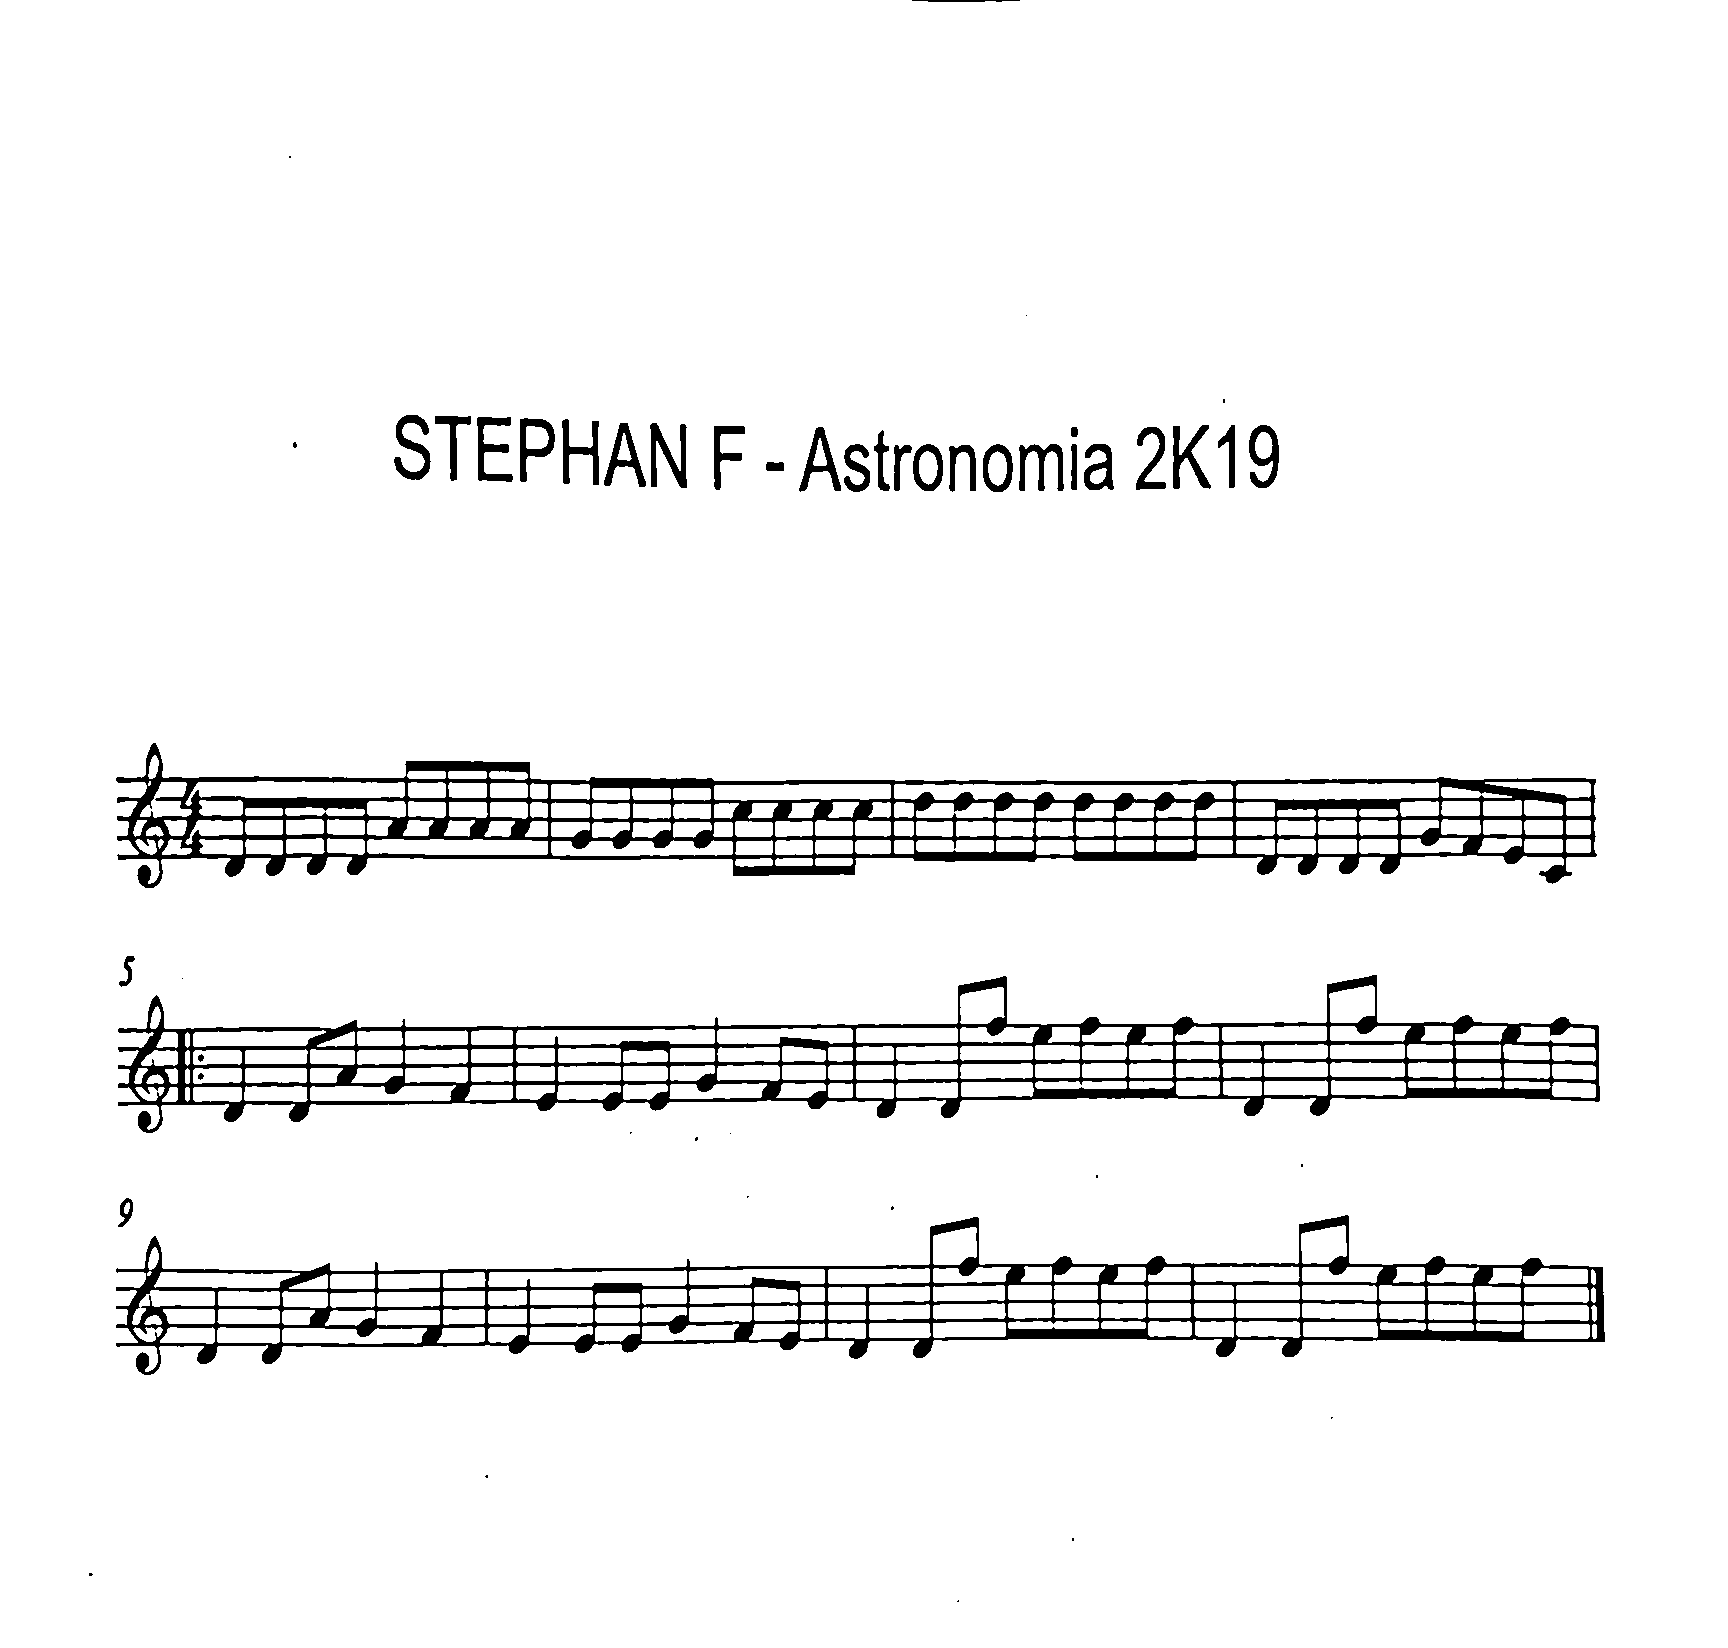

In [19]:
iEspecial = True

if(iEspecial == True):
  gray = img
  
  img = image_resize(img, width= 1800)
  img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,53,7)
  img =  cv2.threshold(img, th, 255, cv2.THRESH_BINARY)[1]
  #img = cv2.medianBlur(img,5)
  img = cv2.GaussianBlur(img,(5,5),0)
  #cv2_imshow(img)
  ret3,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  ha,wa = img.shape
  
  img = img[0+int(ha*0.02):ha-int(ha*0.02),0+int(wa*0.02):wa-int(wa*0.02)]
  gray = img
  col = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
else:
  gray = cv2.imread(im,0)
  gray = image_resize(gray, width= 1800)
  col = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)

cv2_imshow(gray)

In [20]:
csol =cv2.imread(notas+'cSol2.jpg',0)
csol2 = cv2.imread(notas+'cSol3.jpg',0)
csol3 = cv2.imread(notas+'cSol4.jpg',0)
csoles = [csol,csol2,csol3]


blanca1 = cv2.imread(notas+'blanca1.jpg',0)
blanca2 = cv2.imread(notas+'blanca2.jpg',0)

sharp = cv2.imread(notas+'sharp.png',0)
sharp2 = cv2.imread(notas+'sharp2.jpg',0)
sharp3 = cv2.imread(notas+'sharp3.png',0)
sharps =  [sharp,sharp2,sharp3]

bemol = cv2.imread(notas+'bemol.jpg',0)
bemol2 = cv2.imread(notas+'flat2.jpg',0)
bemol3 = cv2.imread(notas+'flat3.jpg',0)
bemoles = [bemol,bemol2,bemol3]


natural = cv2.imread(notas+'natural.jpg',0)
natural2 = cv2.imread(notas+'natural2.png',0)
naturals = [natural,natural2]

compas34 = cv2.imread(notas+'compas34.png',0)
compas42 = cv2.imread(notas+'compas42.jpg',0)
compas44 = cv2.imread(notas+'compas44.jpg',0)


rest = cv2.imread(notas+'rest.png',0)
rest2 = cv2.imread(notas+'rest2.jpg',0)
rests = [rest,rest2]


aperturaRep = cv2.imread(notas+'aperturaRep.png',0)
cierreRep = cv2.imread(notas+'cierreRep.png',0)


# do re mi fa sol la si 
notasK = {0:"C",1:"D",2:"E",3:"F",4:"G",5:"A",6:"B"}


In [21]:
cv2_imshow(cierreRep)

(1648, 1728)


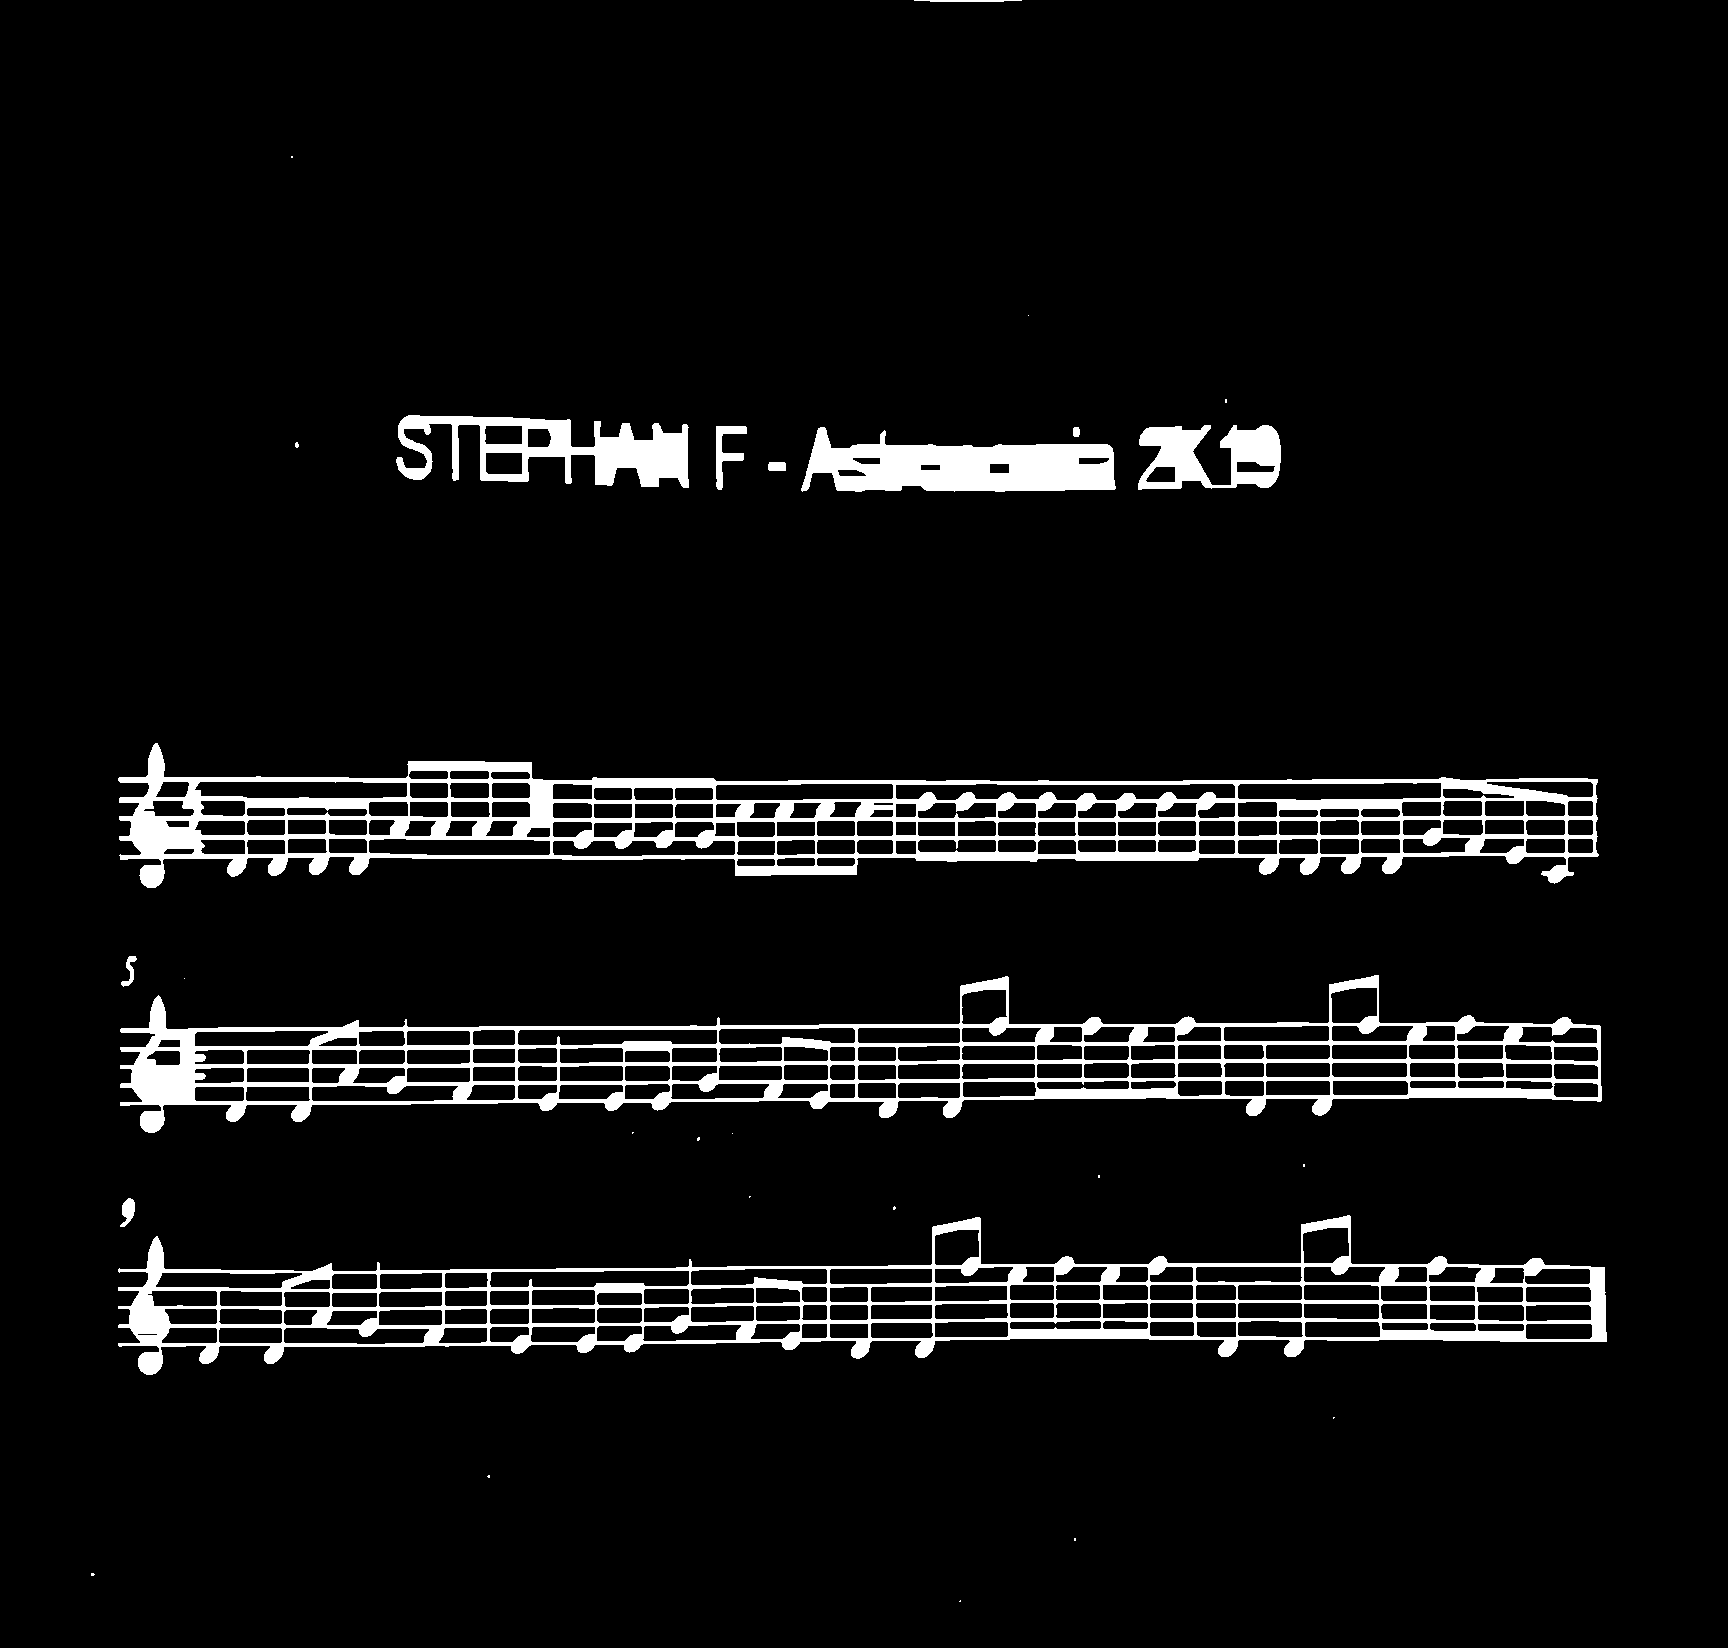

309


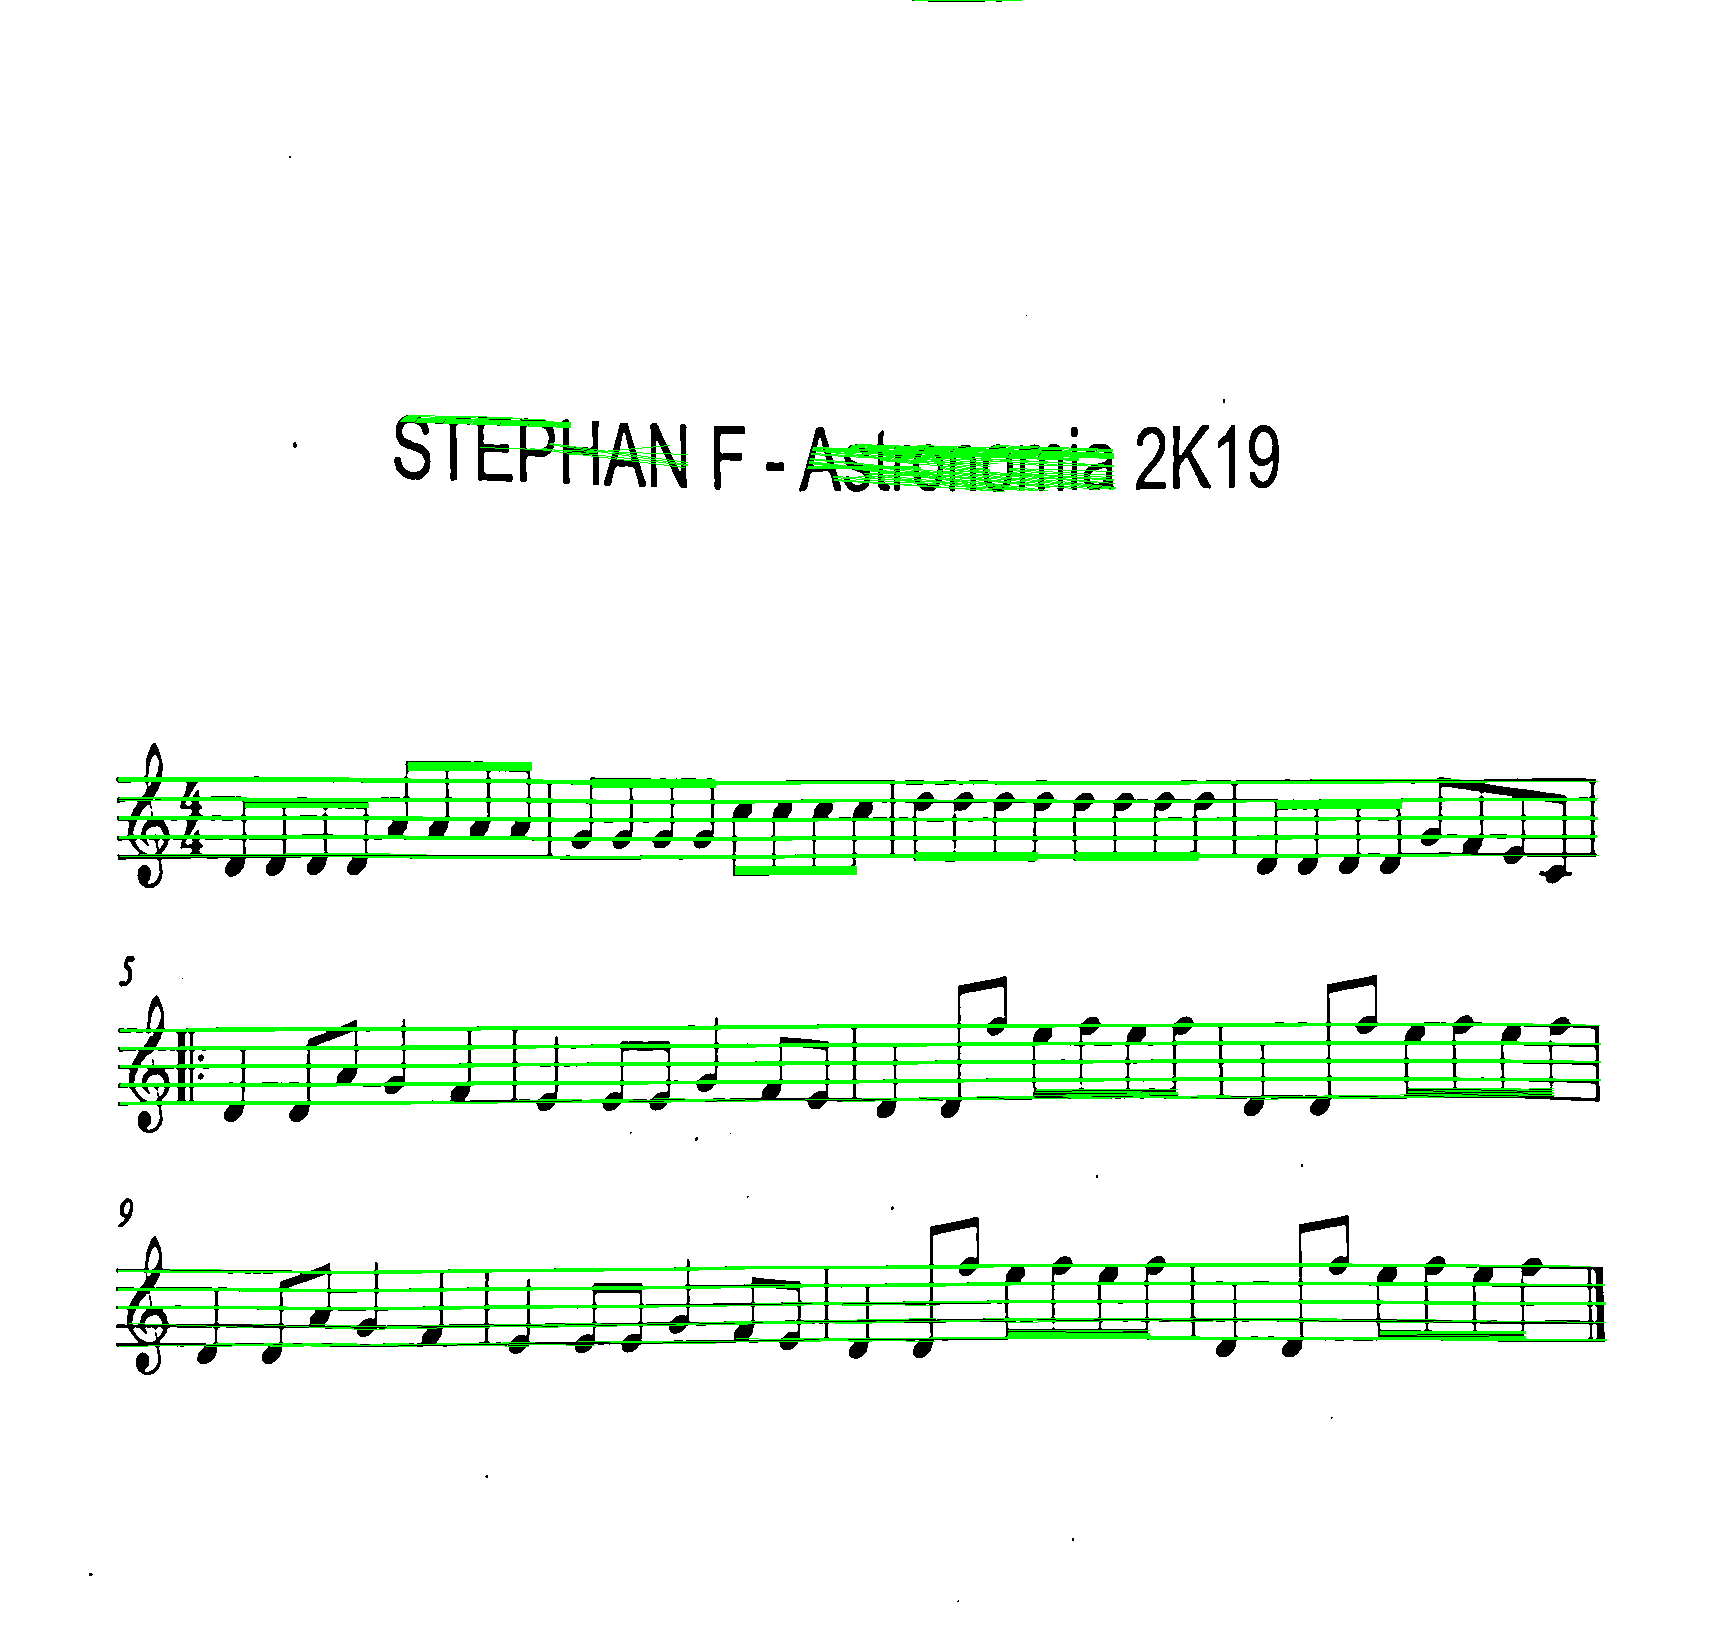

In [22]:
th = 200 #@param = {type:"slider", min:1, max:255} 


if(iEspecial):
  edges = img
  col = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  #edges =cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,21,7)
#blanco como negro
else:
  ret,edges = cv2.threshold(gray,th,255,cv2.THRESH_BINARY)
  col = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)

## Buenos threseholds 190 255

#cv2_imshow(edges)
#gray = cv2.GaussianBlur(gray,(5,5),0)
#cv2_imshow(gray)

#edges = cv2.Canny(gray, 50, 200)
edges = cv2.bitwise_not(edges)
#cv2_imshow(edges)
print(edges.shape)
defau = edges.shape[1]

edgesC = copy.deepcopy(edges)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,1))

edgesC = cv2.morphologyEx(edgesC, cv2.MORPH_CLOSE, kernel,iterations=2)
cv2_imshow(edgesC)



min_line_length = 99 #@param = {type:"slider", min:1, max:3000} 
max_line_gap = 13 #@param = {type:"slider", min:1, max:1000}
lines = cv2.HoughLinesP(edgesC, 1, np.pi/180, 20, minLineLength=min_line_length, maxLineGap=max_line_gap)

lineasH = []
h = 0
setW = set()
for line in lines:
  x1, y1, x2, y2 = line[0]
  w = x2-x1
  if(w >=min_line_length):
    setW.add(w)
    cv2.line(col,(x1,y1),(x2,y2),(0,255,0),1)
    if(y1 == y2):
      lineasH.append(line)


print(len(lines))
lineasH.sort(key=lambda x:x[0][1])
cv2_imshow(col)



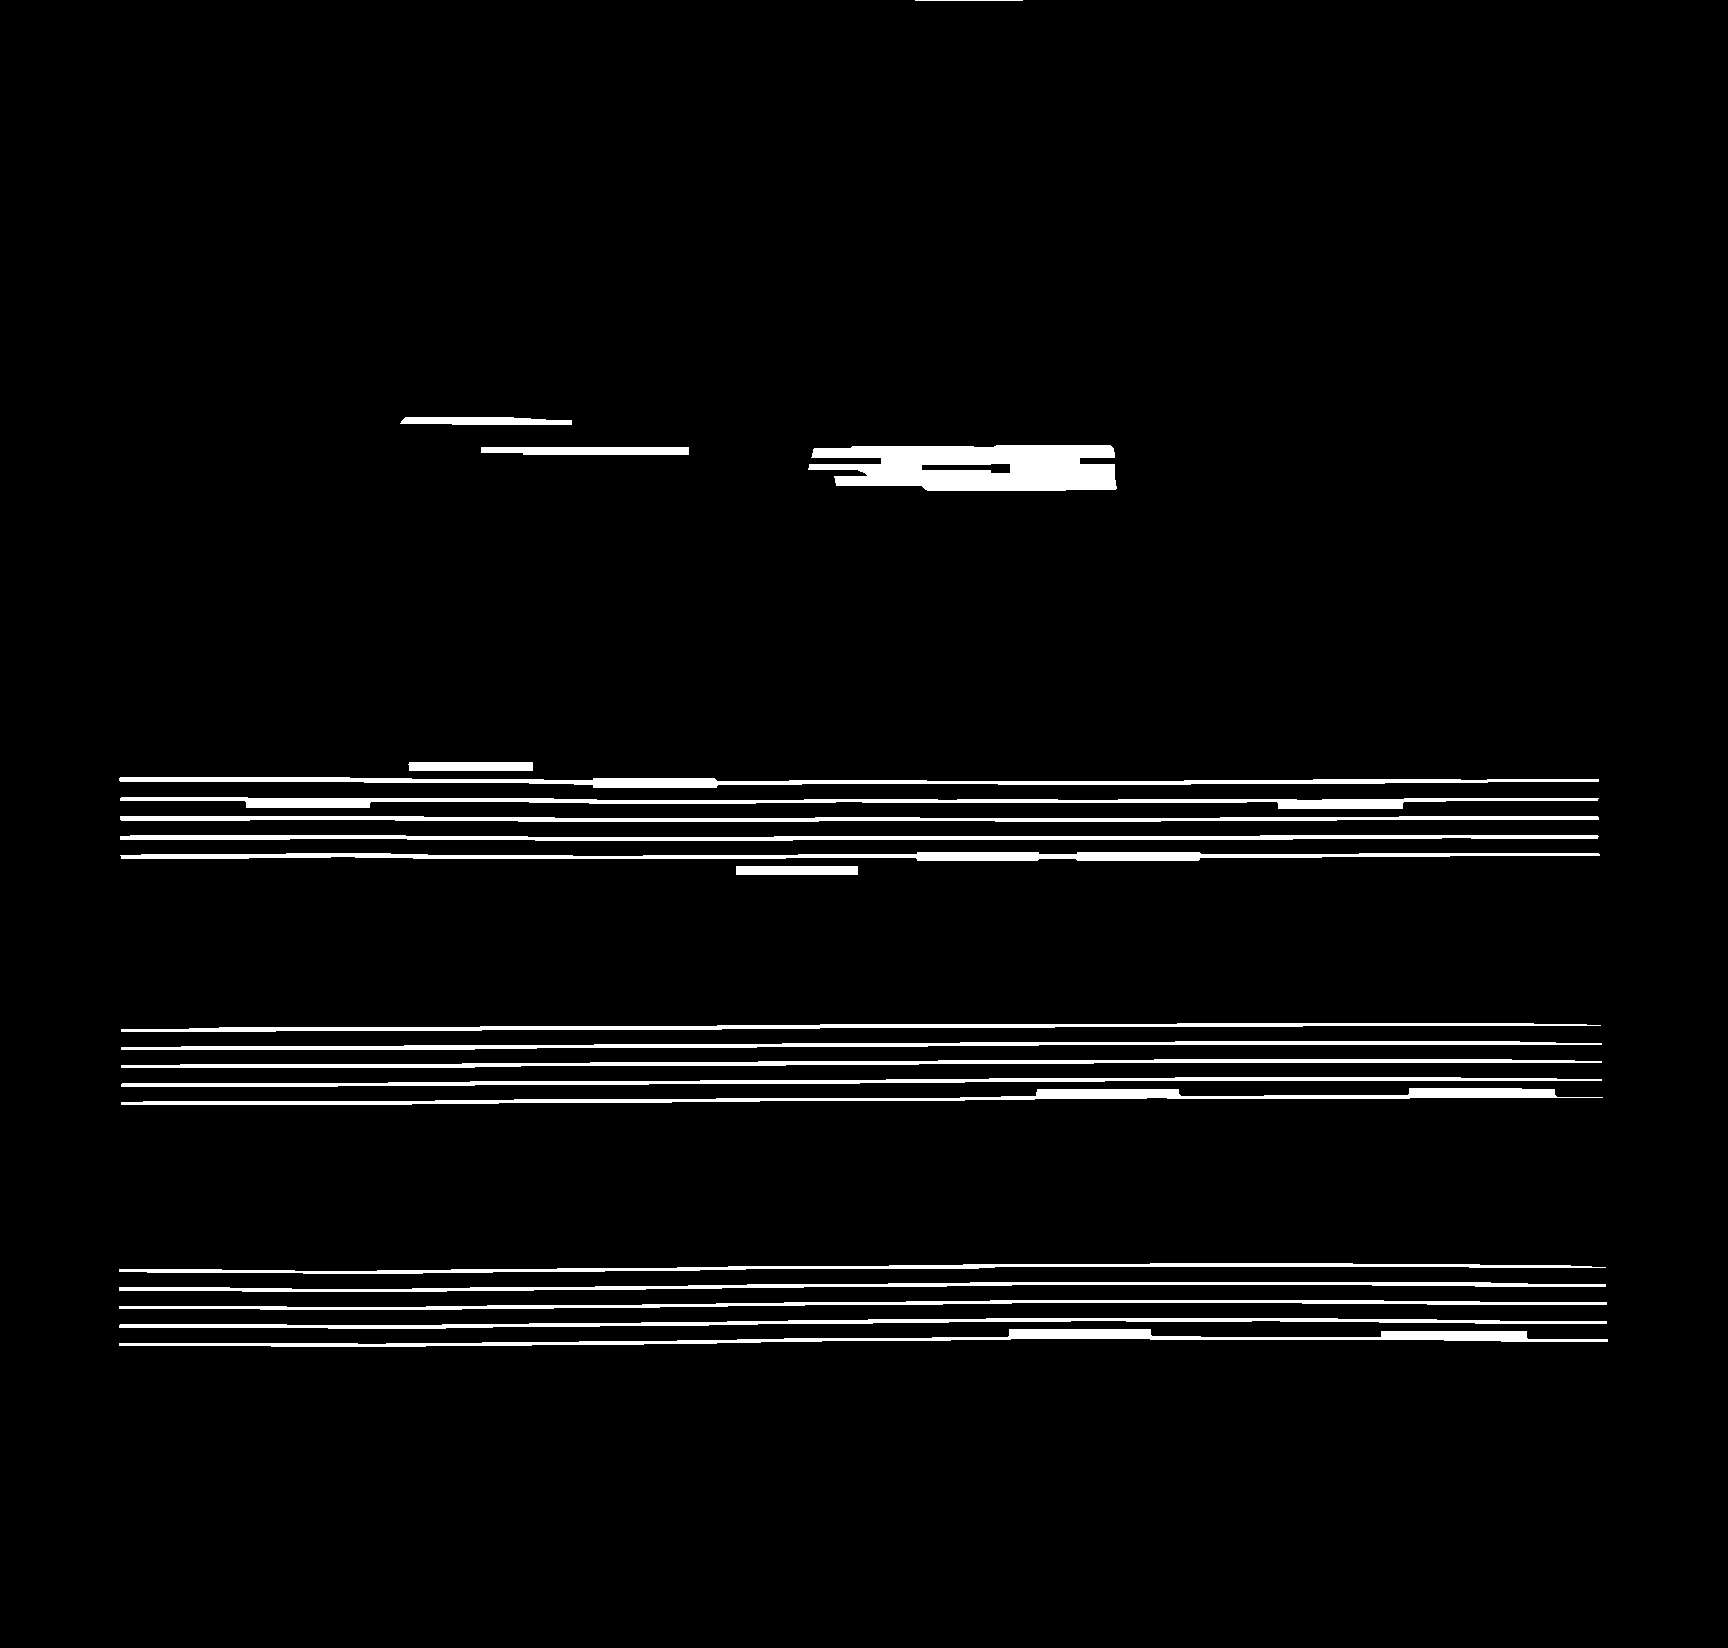

In [23]:
#a = edges

a =  cv2.cvtColor(col, cv2.COLOR_BGR2GRAY)


a = cv2.GaussianBlur(a,(5,5),0)
ret,a = cv2.threshold(gray,th,255,cv2.THRESH_BINARY)
#cv2_imshow(a)
#a =cv2.adaptiveThreshold(a,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,21,7)
a = cv2.bitwise_not(a)
#cv2_imshow(a)
imgF = np.zeros((a.shape[0],a.shape[1]), np.uint8)

#NUEVO
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,1))
a = cv2.morphologyEx(a, cv2.MORPH_CLOSE, kernel,iterations=2)
#A
#cv2_imshow(a)
mnww = 2000
for w in setW:
  if(w > 0):
    mnww = min(mnww,w)
    #print(h)

ln = cv2.getStructuringElement(cv2.MORPH_RECT,(mnww,1))
act = cv2.erode(a,ln)
act = cv2.dilate(act,ln)
#act = cv2.bitwise_not(act)
imgF = cv2.bitwise_or(imgF,act)


#blur = cv2.blur(imgF, (2,2)) #borramiento: filtro pasa bajas
#imgF = cv2.Canny(blur, 20, 200)
#imgF = cv2.bitwise_not(imgF)
contours, _ = cv2.findContours(imgF, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
colT = cv2.cvtColor(imgF, cv2.COLOR_GRAY2BGR)
cv2_imshow(imgF)


imgF1 = copy.deepcopy(imgF)


21


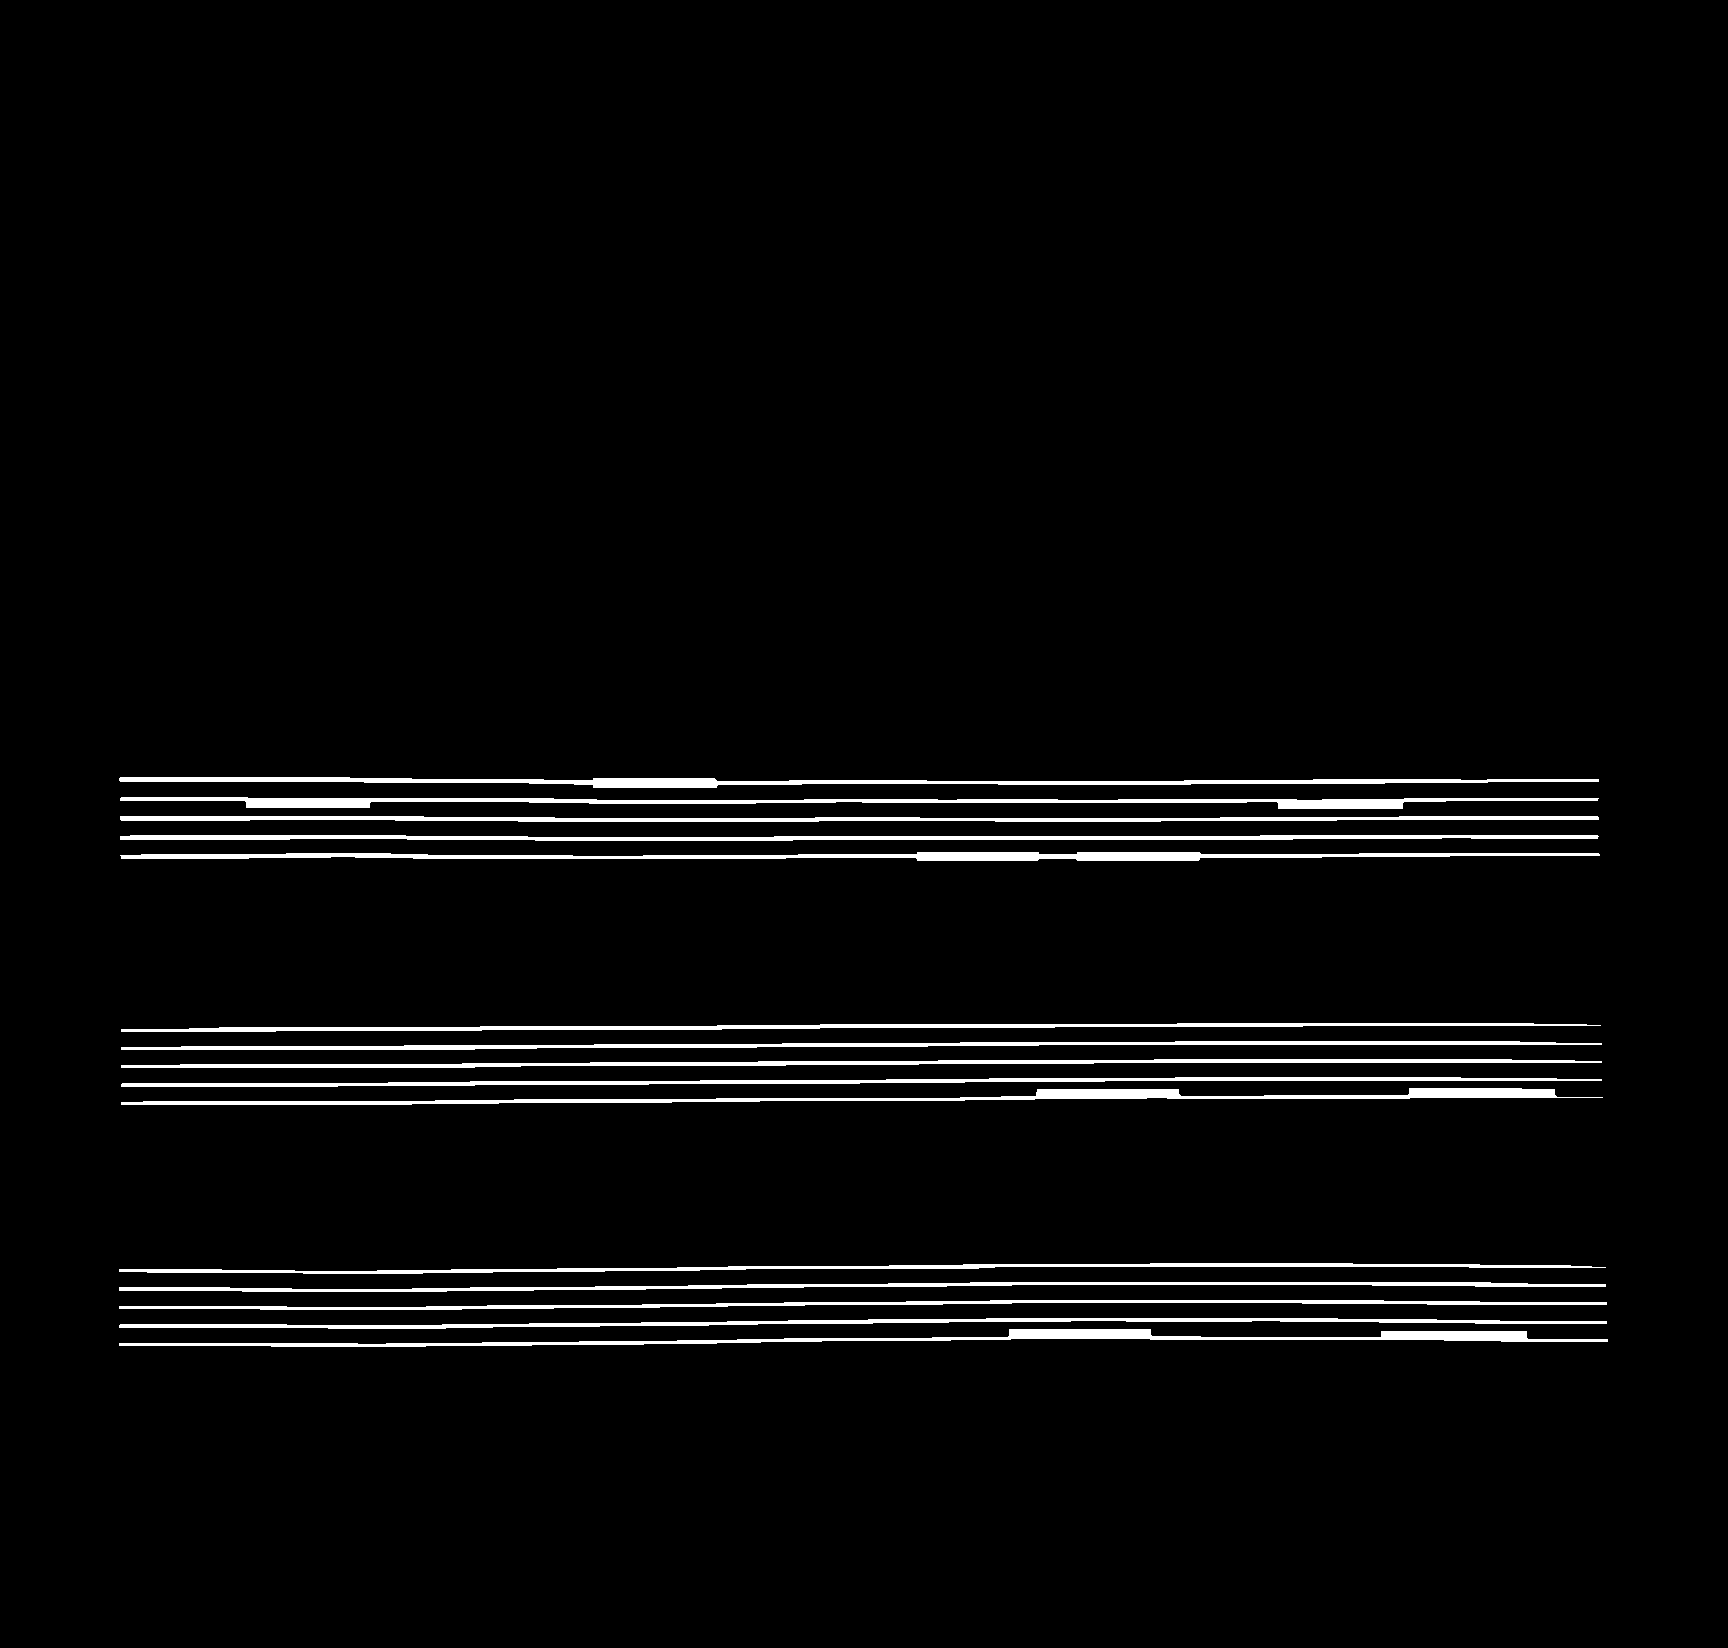

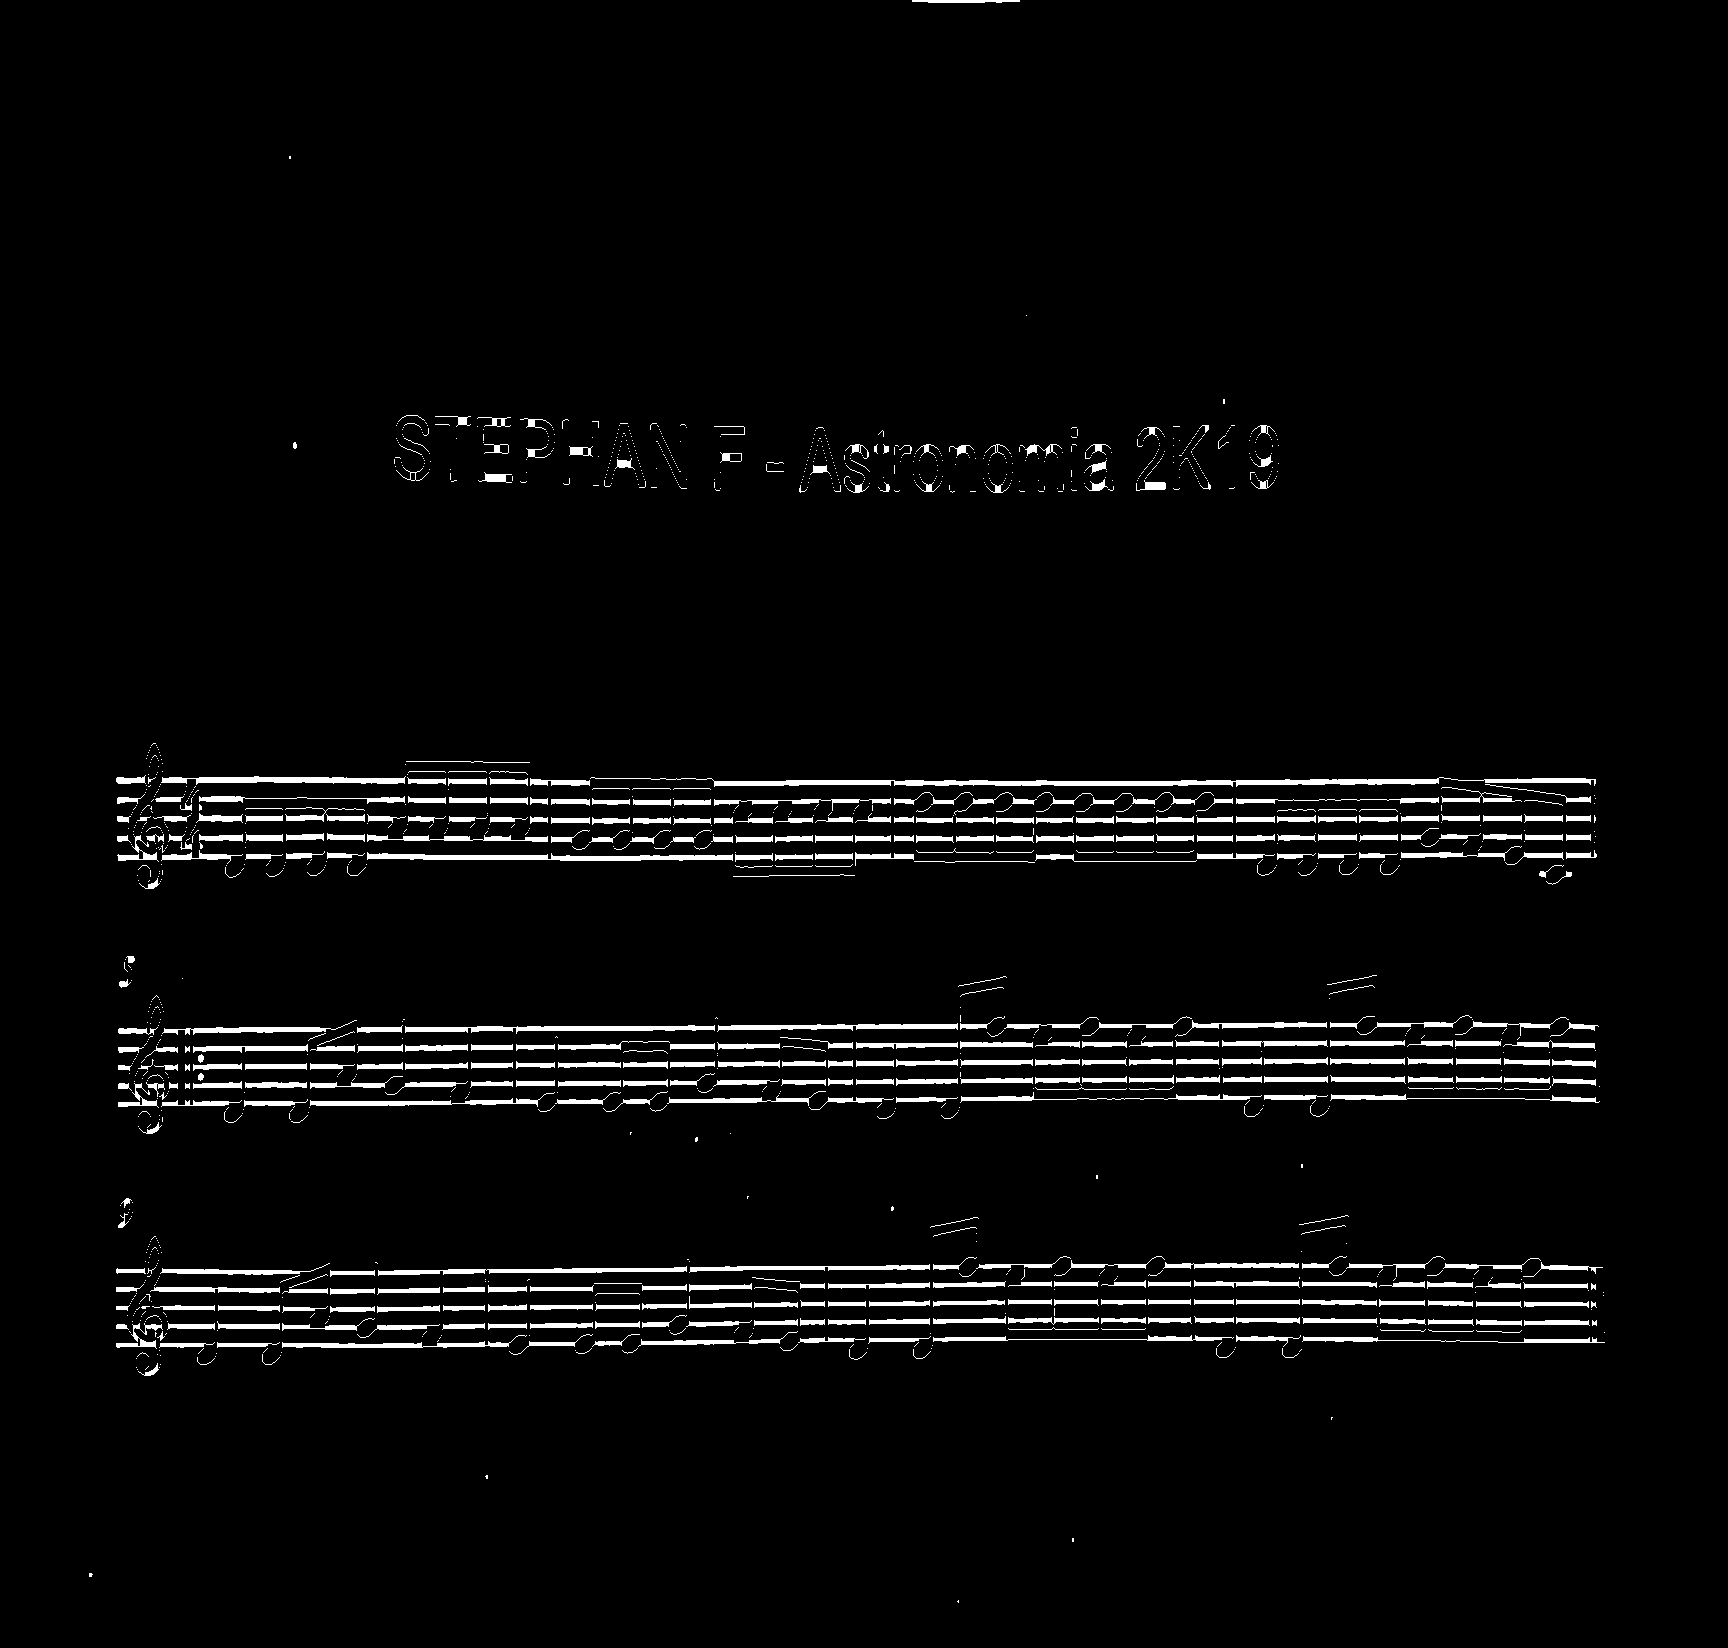

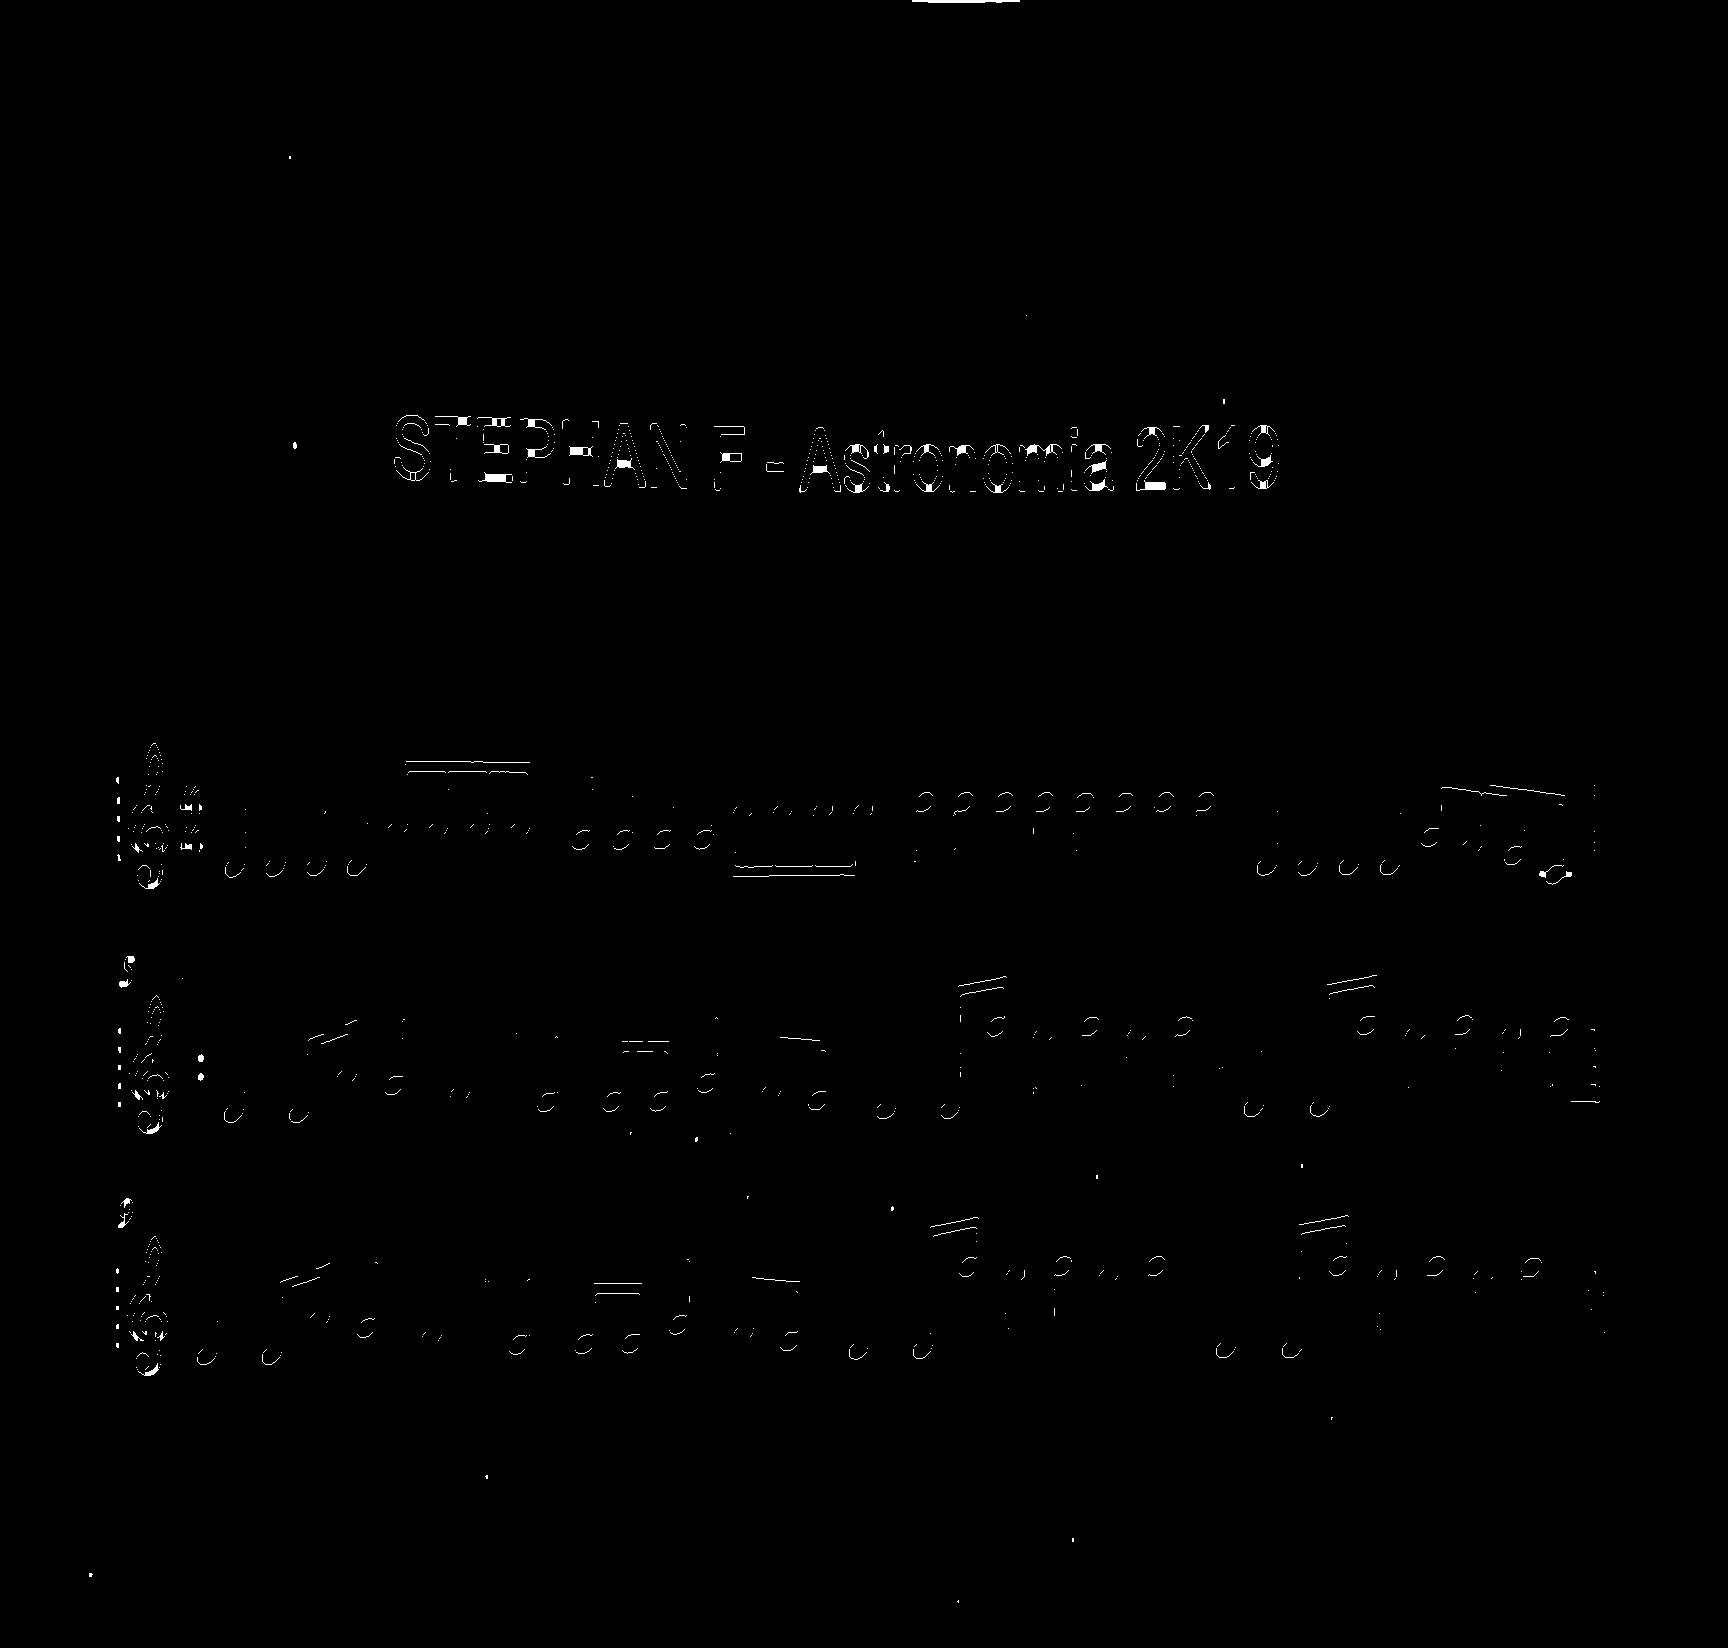

In [24]:
#a = edges
imgF = copy.deepcopy(imgF1)
a =  cv2.cvtColor(col, cv2.COLOR_BGR2GRAY)


#a = cv2.GaussianBlur(a,(5,5),0)
ret,a = cv2.threshold(gray,th,255,cv2.THRESH_BINARY)
a = cv2.bitwise_not(a)

#cv2.drawContours(colT, contours, -1, (0,255,0), 1)
ROIs = []

contours2 = []
mnh = 10000
posis = []
#cv2_imshow(imgF)
print(len(contours))
for contour in contours:
  x,y,w,h = cv2.boundingRect(contour)
  posis.append((y,h))
  ROIs.append((x,y,w,h))

  if(w >= defau//2):
    contours2.append(contour)
    mnh = min(h,mnh)
  else:
    imgF[y:y+h,x:x+w] = 0

cv2_imshow(imgF)


#print(len(contours2))
zz = copy.deepcopy(a)
it =  7#@param  
taa = copy.deepcopy(imgF)

Ca = np.zeros((a.shape[0],a.shape[1]), np.uint8)

k = cv2.getStructuringElement(cv2.MORPH_RECT,(1,mnh))
zzzF = cv2.dilate(imgF,k) 

mnh = 1
for i in range(0,it):
  k = cv2.getStructuringElement(cv2.MORPH_RECT,(1,mnh+1+i))
  zz= cv2.erode(a,k)
  zz= cv2.dilate(zz,k)
  cambios = cv2.bitwise_xor(a,zz)
  #cv2_imshow(cambios)
  Ca = cv2.bitwise_or(Ca,cambios)


#SI HAY PROBLEMAS COMENTAR ESTA PARTE
  #cv2_imshow(zz)

#cv2_imshow(zzzF)
cv2_imshow(Ca)
Ca = cv2.subtract(Ca,zzzF)
cv2_imshow(Ca)

#AAA

zz = cv2.add(zz,Ca)
#cv2_imshow(zz)

'''
for y,h in posis:
  actt = zz[y:y+h+1,0:zz.shape[1]]

  kernel = np.ones((1,int(defau * 0.01)),np.uint8)
  actt = cv2.morphologyEx(actt, cv2.MORPH_CLOSE, kernel)

  zz[y:y+h+1,0:zz.shape[1]] = actt
'''
#cv2_imshow(zz)

#contours = contours2
  #cv2_imshow(imgF[y:y+h,x:x+w])


contours2.sort(key=lambda x:cv2.boundingRect(x)[1])
BORRADOS = True
if(BORRADOS == False):
  a = cv2.bitwise_xor(imgF,a)

else:
  a = zz


[[1]
 [1]]


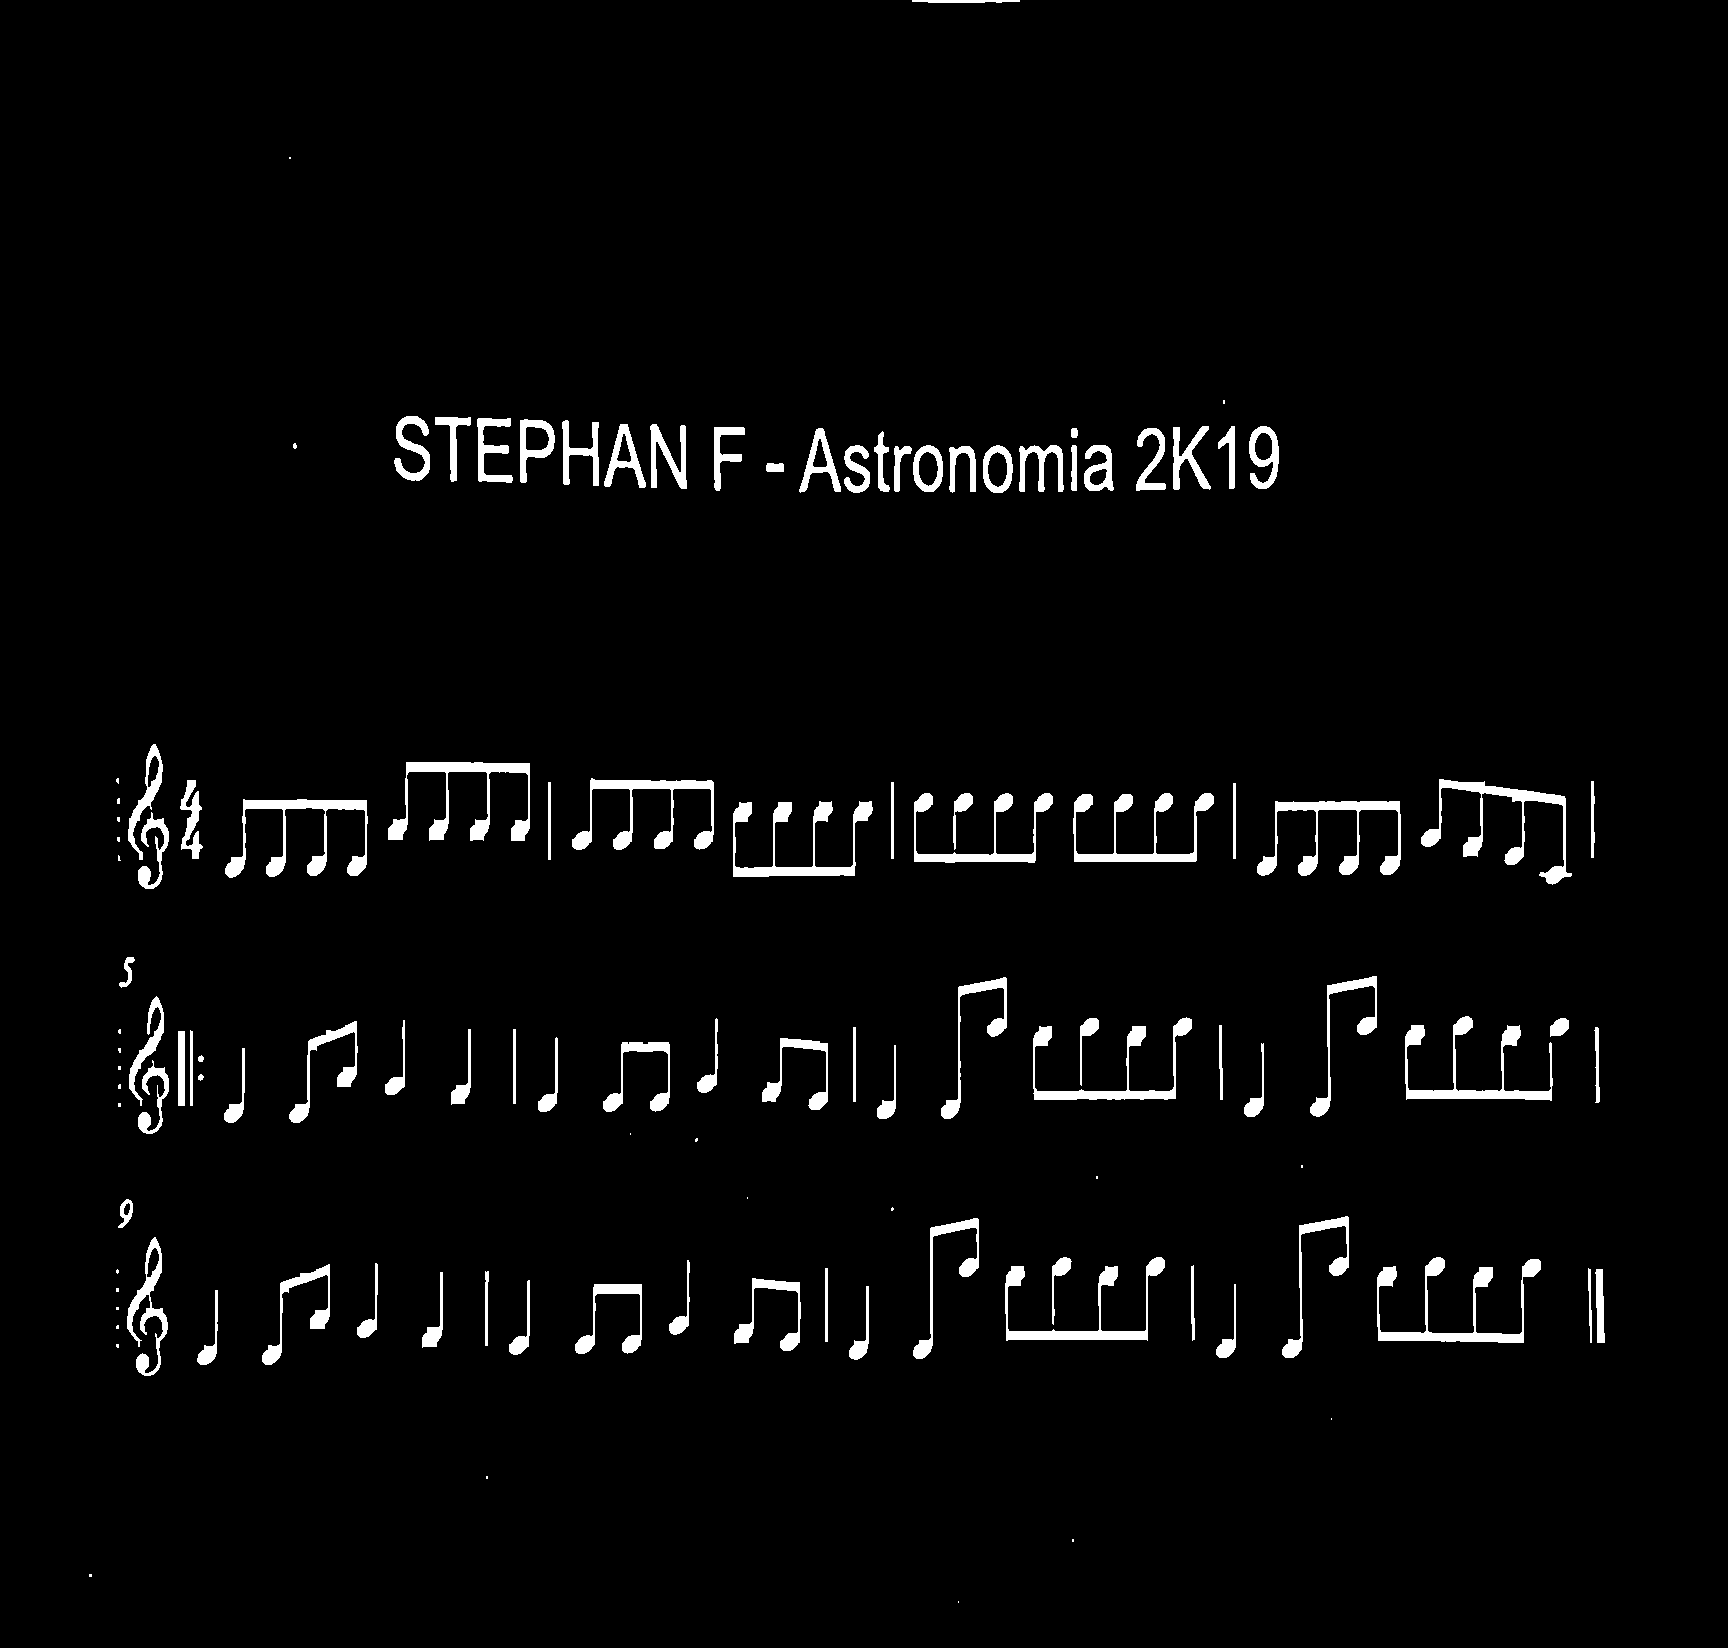

In [25]:
a = cv2.bitwise_not(a);

contours = contours2
#cv2_imshow(a)
kernel = np.ones((2,1),np.uint8)
print(kernel)


a = cv2.bitwise_not(a);
nm = cv2.erode(a,kernel)
cv2_imshow(nm)

#nm = cv2.blur(nm, (5, 5), 0)
a = nm
imgO = a

In [26]:
'''
kernel = np.ones((3,1),np.uint8)
print(kernel)
f = cv2.morphologyEx(a, cv2.MORPH_CLOSE, kernel)
kernel = np.ones((1,3),np.uint8)
f = cv2.morphologyEx(f, cv2.MORPH_CLOSE, kernel)
cv2_imshow(f)
a = f



a = cv2.bitwise_not(a)
'''


'\nkernel = np.ones((3,1),np.uint8)\nprint(kernel)\nf = cv2.morphologyEx(a, cv2.MORPH_CLOSE, kernel)\nkernel = np.ones((1,3),np.uint8)\nf = cv2.morphologyEx(f, cv2.MORPH_CLOSE, kernel)\ncv2_imshow(f)\na = f\n\n\n\na = cv2.bitwise_not(a)\n'

#Verificación

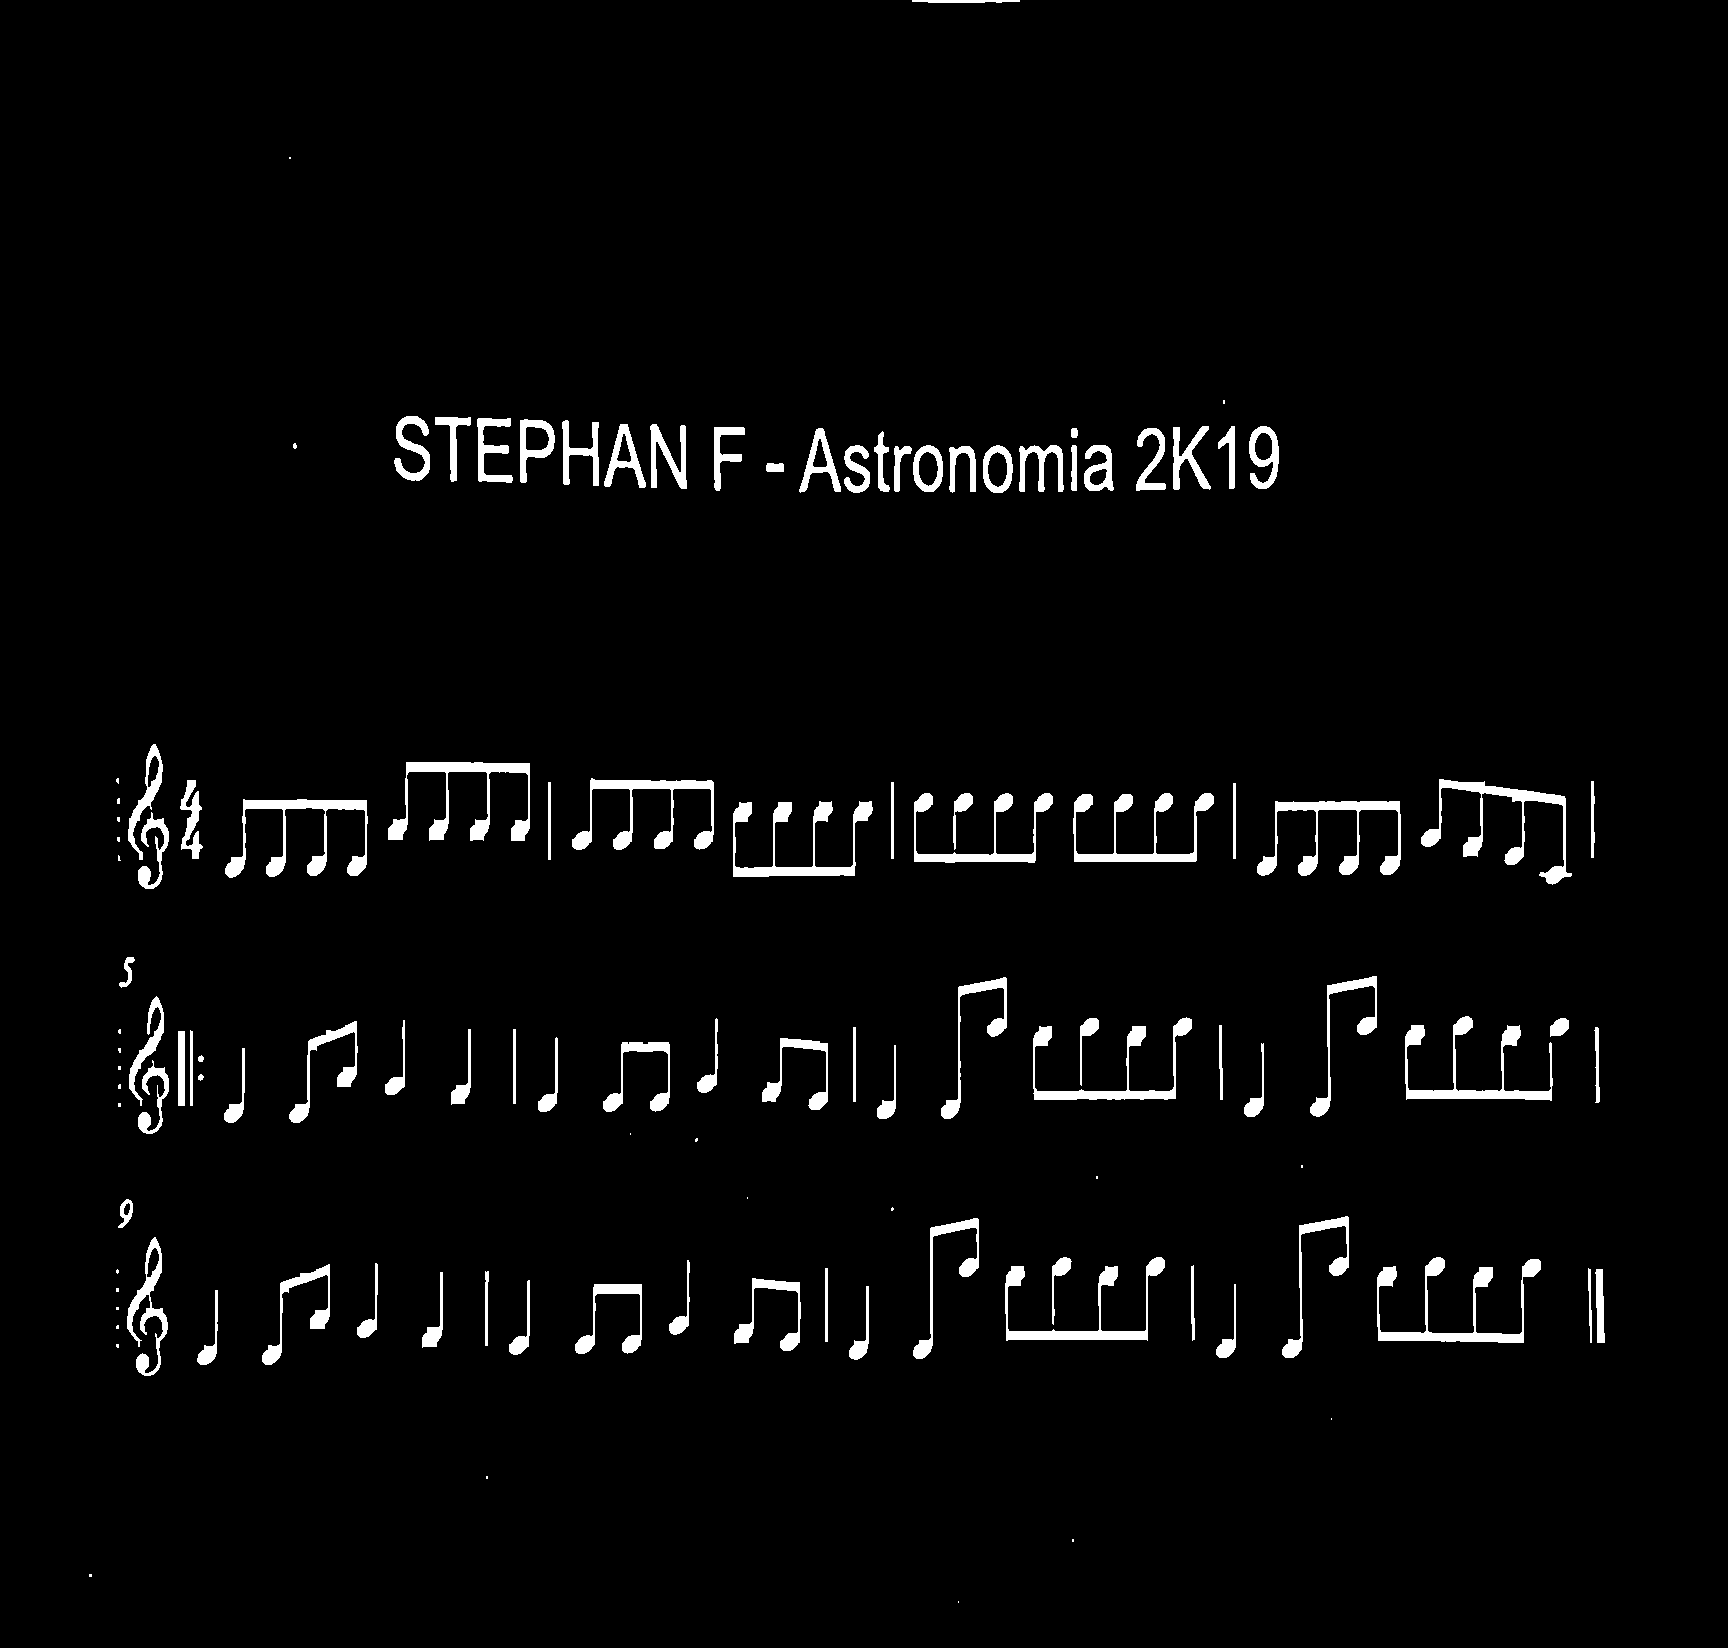

(1648, 1728)


In [27]:
cv2_imshow(a)
print(a.shape)

#Extracción de Características y Reconocimiento de Patrones

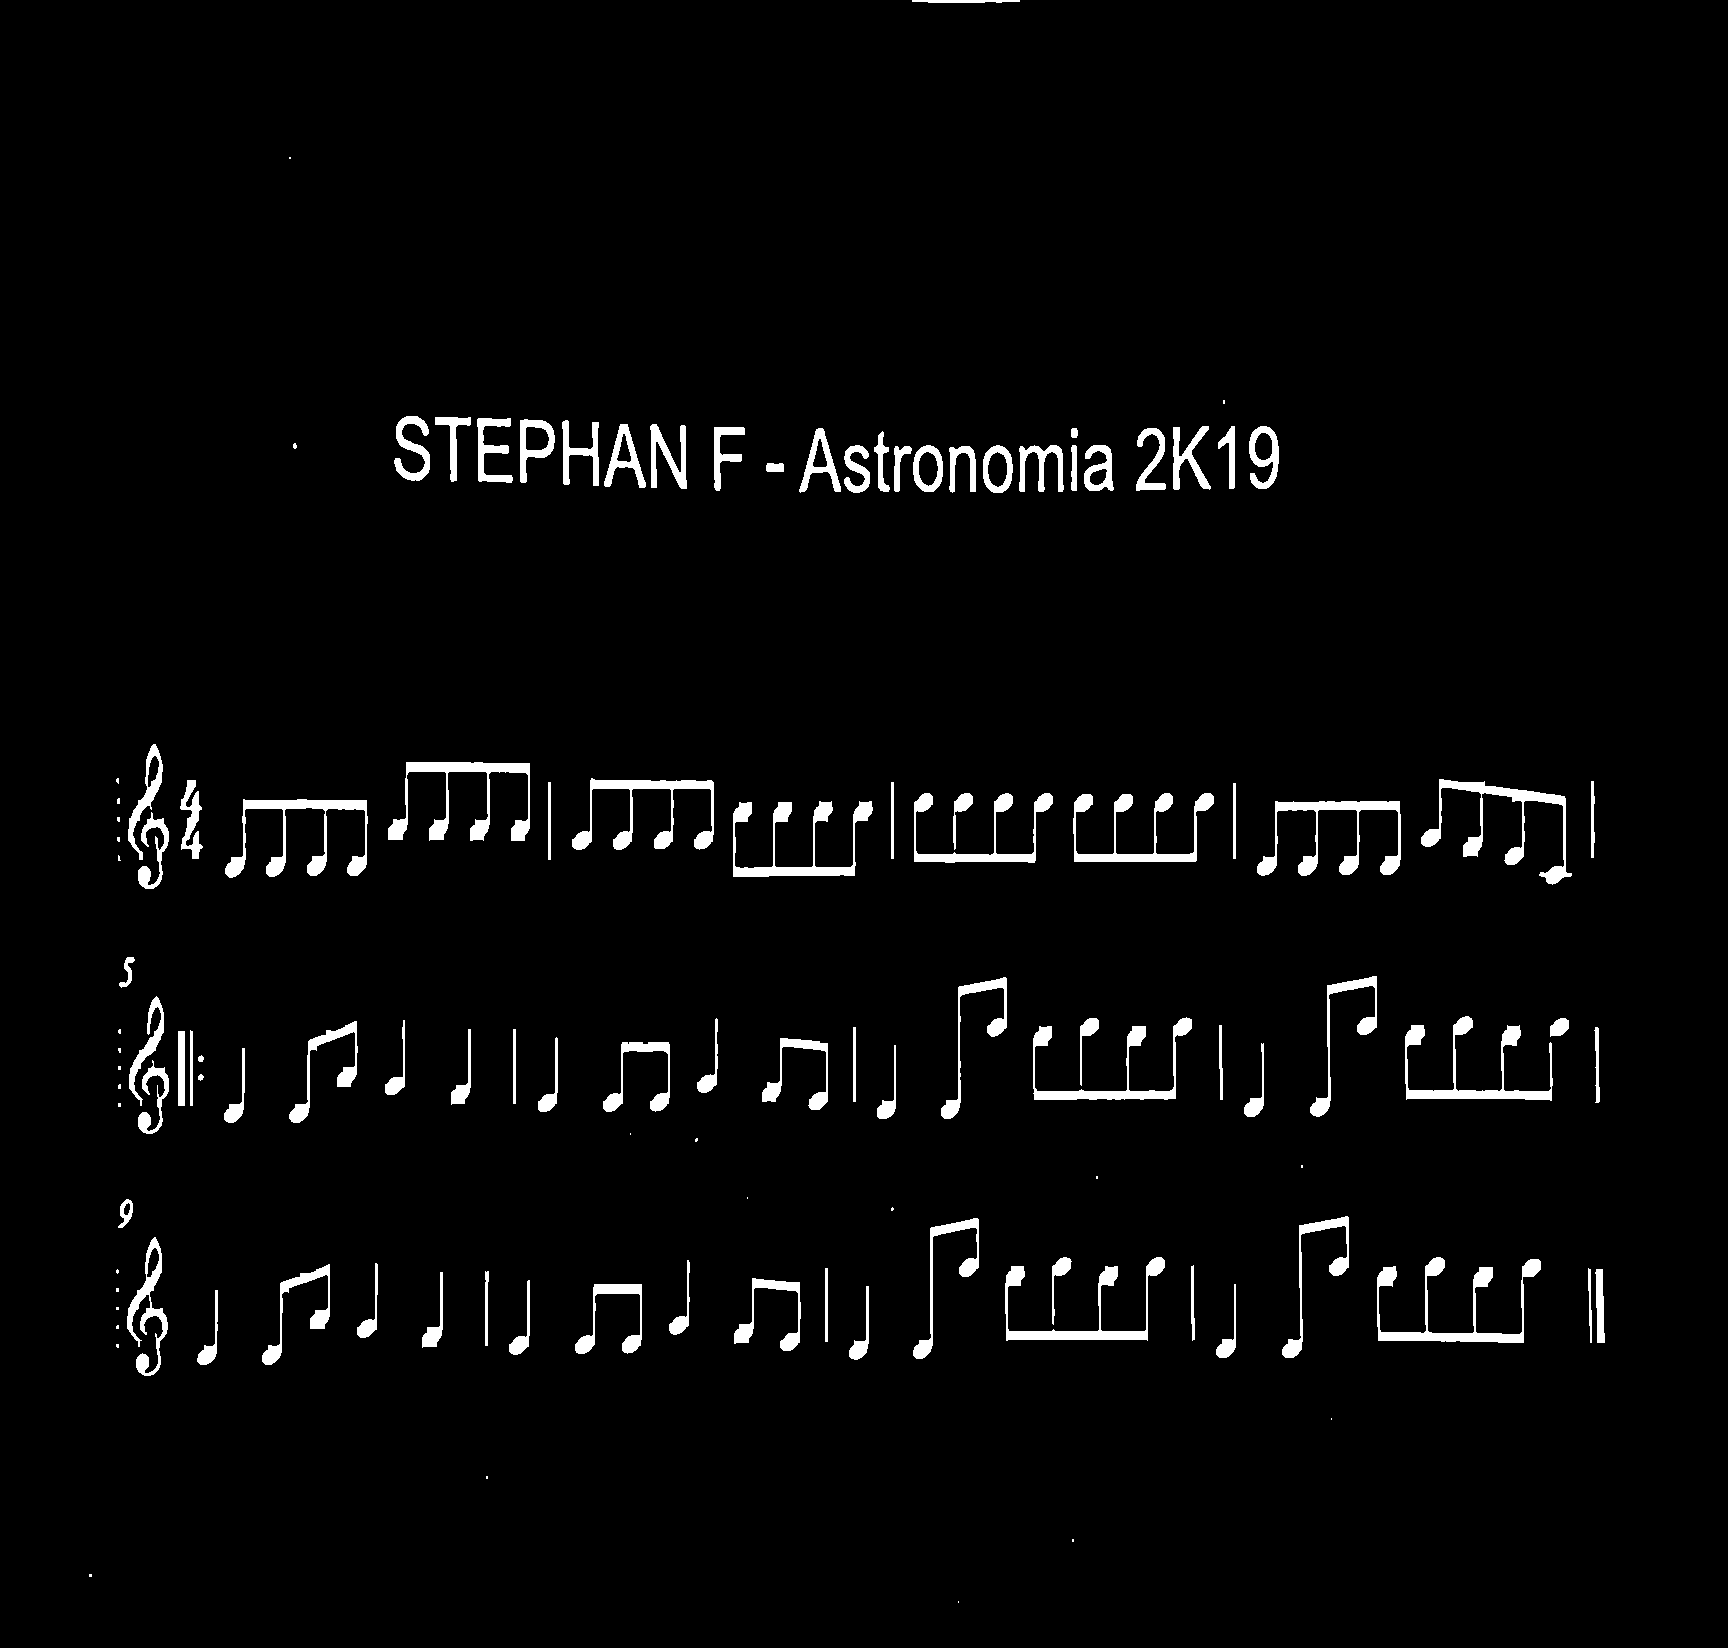

15
85
ESPACIOS: 18 21 4


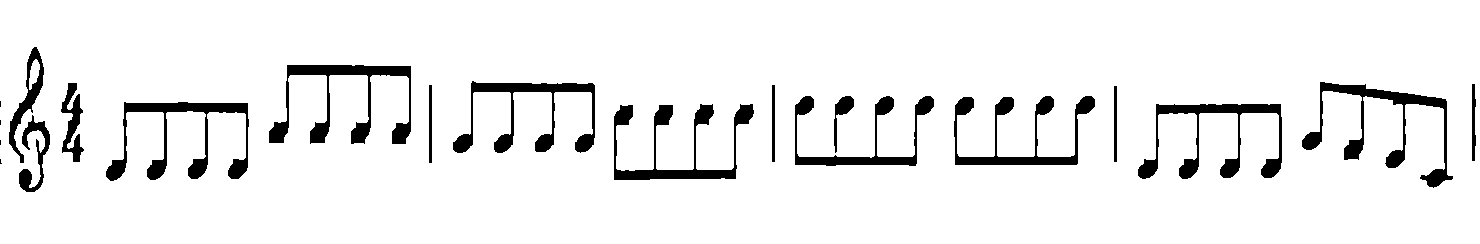

18
(244, 1480)


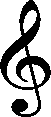

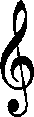

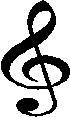

0
CSOL
[-1, -1, -1, -1]


[51, 59, 72, 27]


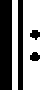

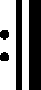

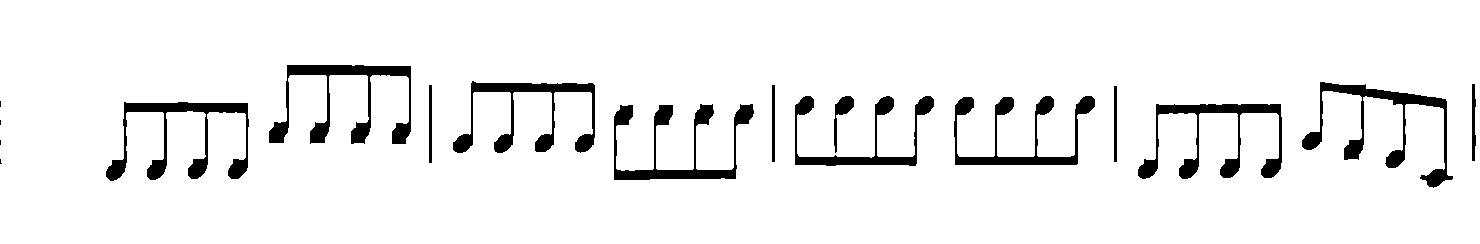

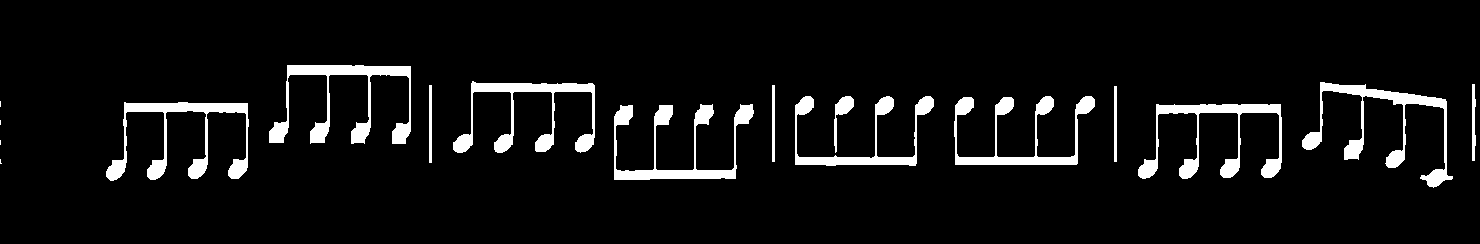

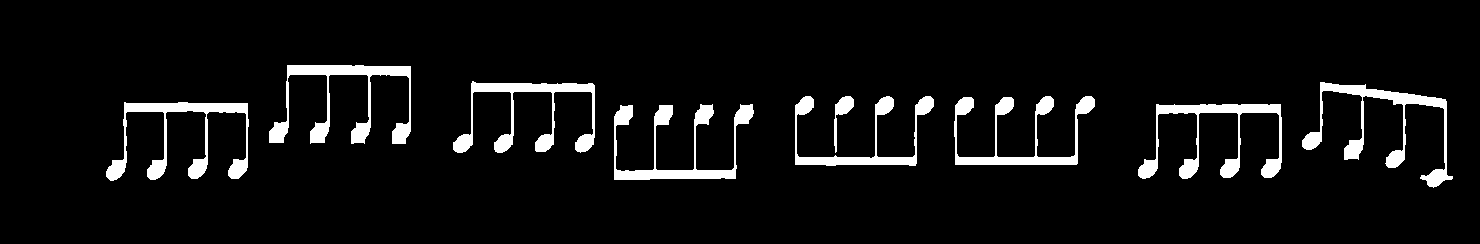

DETECTA BLANCAS


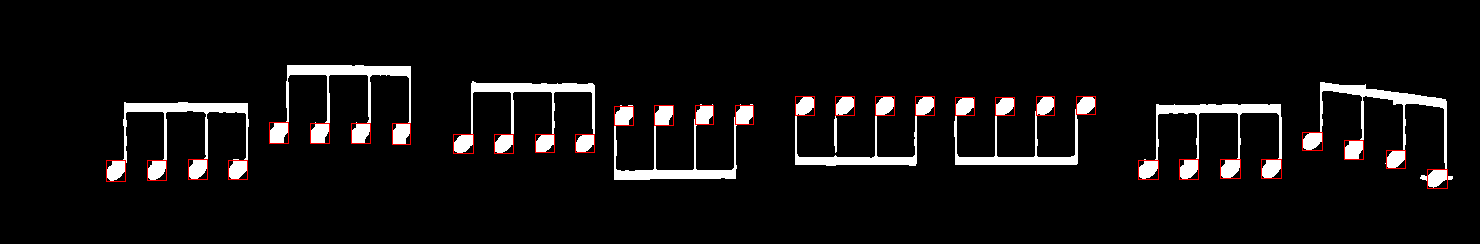

32
(0, 140, 5, 1, 'puntillo')
(0, 120, 5, 1, 'puntillo')
(0, 101, 6, 1, 'puntillo')
(0, 159, 5, 2, 'puntillo')
(429, 85, 78, 3, 'compas')
(772, 85, 77, 3, 'compas')
(1114, 86, 76, 3, 'compas')
(1472, 84, 77, 4, 'compas')
[(106, 160, 19, 21), 8, 'Corchea', 'E']
[(147, 160, 19, 20), 8, 'Corchea', 'E']
[(188, 159, 19, 20), 8, 'Corchea', 'E']
[(228, 160, 19, 19), 8, 'Corchea', 'E']
[(269, 122, 19, 21), 7, 'Corchea', 'B']
[(310, 123, 19, 20), 7, 'Corchea', 'A']
[(351, 123, 19, 20), 7, 'Corchea', 'A']
[(392, 123, 18, 21), 7, 'Corchea', 'A']
[(453, 134, 20, 19), 4, 'Corchea', 'G']
[(494, 134, 19, 19), 4, 'Corchea', 'G']
[(535, 134, 19, 18), 4, 'Corchea', 'G']
[(575, 134, 19, 18), 4, 'Corchea', 'G']
[(614, 106, 19, 19), 5, 'Corchea', 'C']
[(654, 105, 19, 20), 5, 'Corchea', 'C']
[(695, 105, 18, 19), 5, 'Corchea', 'C']
[(735, 105, 18, 19), 5, 'Corchea', 'C']
[(795, 96, 19, 19), 3, 'Corchea', 'D']
[(835, 96, 19, 19), 1, 'Negra', 'D']
[(875, 96, 19, 19), 3, 'Corchea', 'D']
[(915, 96, 19, 19), 3, '

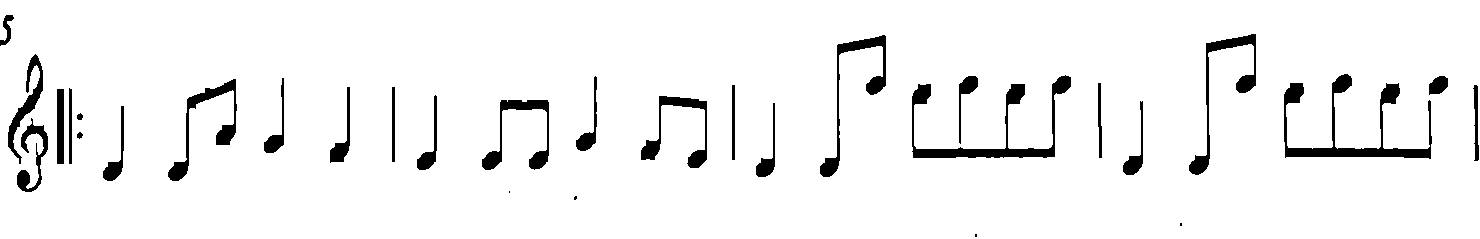

17
(239, 1480)


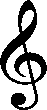

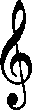

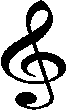

0
CSOL
[-1, -1, -1, -1]


[51, 59, 72, 27]


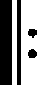

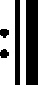

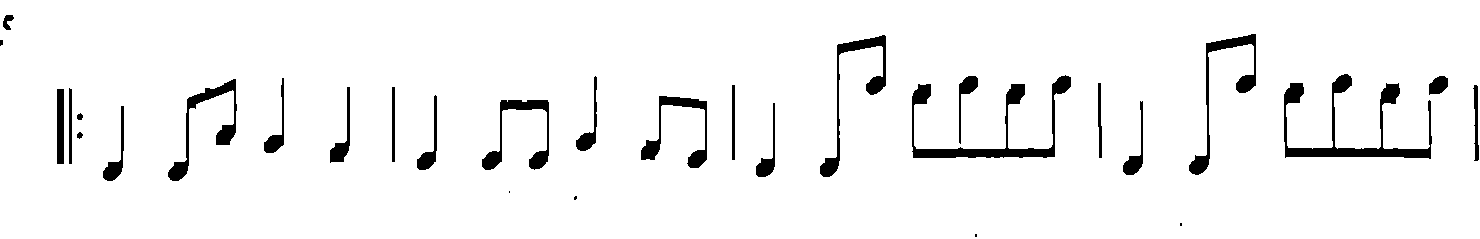

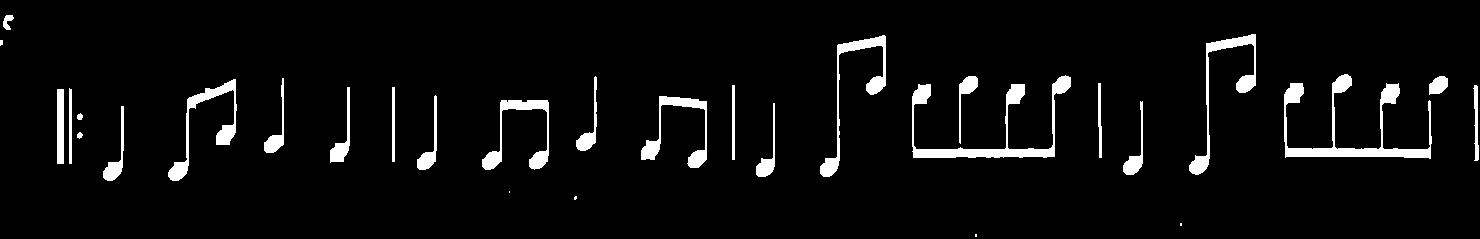

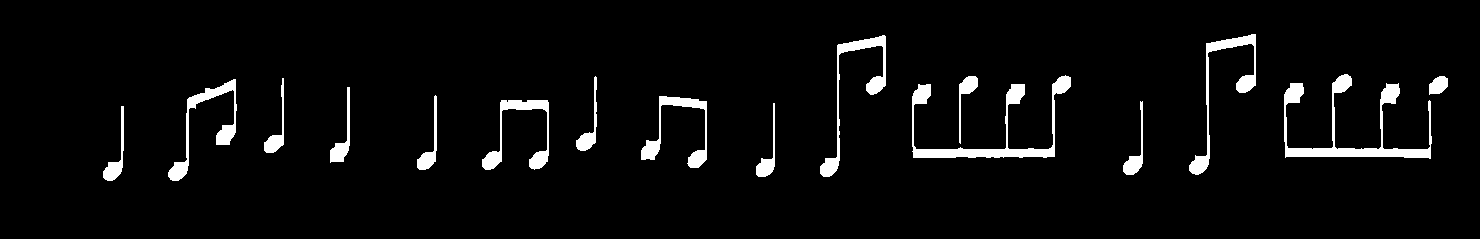

DETECTA BLANCAS


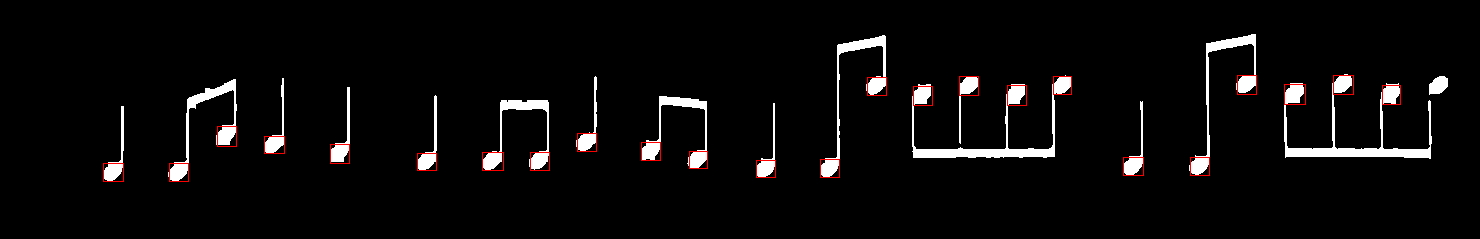

24
(0, 40, 6, 3, 'puntillo')
(3, 15, 15, 11, 'puntillo')
(57, 89, 75, 7, 'compas')
(69, 88, 76, 3, 'compas')
(77, 132, 7, 6, 'puntillo')
(77, 113, 7, 6, 'puntillo')
(392, 87, 75, 3, 'compas')
(509, 191, 2, 1, 'puntillo')
(574, 196, 4, 3, 'puntillo')
(732, 85, 75, 3, 'compas')
(975, 234, 3, 2, 'puntillo')
(1098, 83, 75, 4, 'compas')
(1180, 223, 3, 2, 'puntillo')
(1473, 85, 76, 6, 'compas')
[(103, 163, 20, 18), 16, 'Negra', 'D']
[(169, 163, 19, 18), 20, 'Corchea', 'D']
[(217, 126, 19, 20), 20, 'Corchea', 'G']
[(264, 136, 20, 17), 14, 'Negra', 'F']
[(330, 144, 19, 19), 15, 'Negra', 'F']
[(417, 153, 19, 17), 13, 'Negra', 'E']
[(482, 152, 21, 18), 18, 'Corchea', 'E']
[(530, 152, 19, 18), 18, 'Corchea', 'E']
[(577, 133, 19, 18), 17, 'Negra', 'G']
[(641, 142, 19, 18), 19, 'Corchea', 'F']
[(689, 151, 18, 17), 19, 'Corchea', 'F']
[(756, 160, 19, 17), 11, 'Negra', 'D']
[(820, 159, 19, 18), 21, 'Corchea', 'D']
[(867, 77, 19, 18), 21, 'Corchea', 'F']
[(913, 86, 19, 19), 24, 'Corchea', 'E']
[(959, 

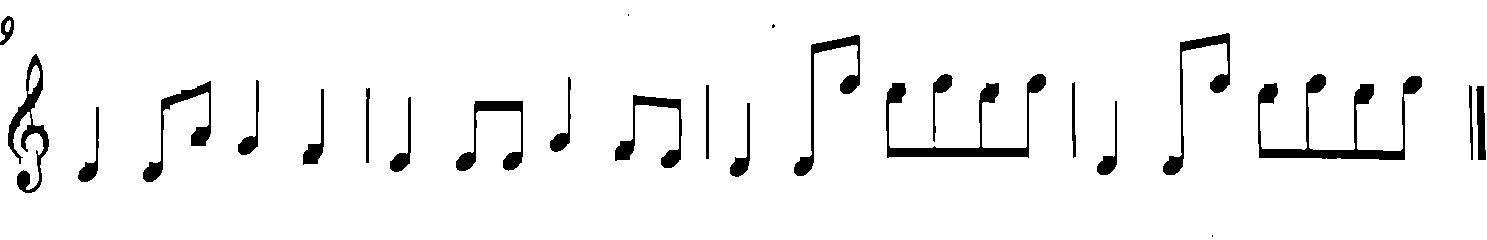

17
(240, 1487)


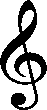

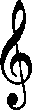

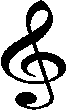

0
CSOL
[-1, -1, -1, -1]


[51, 59, 72, 27]


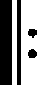

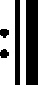

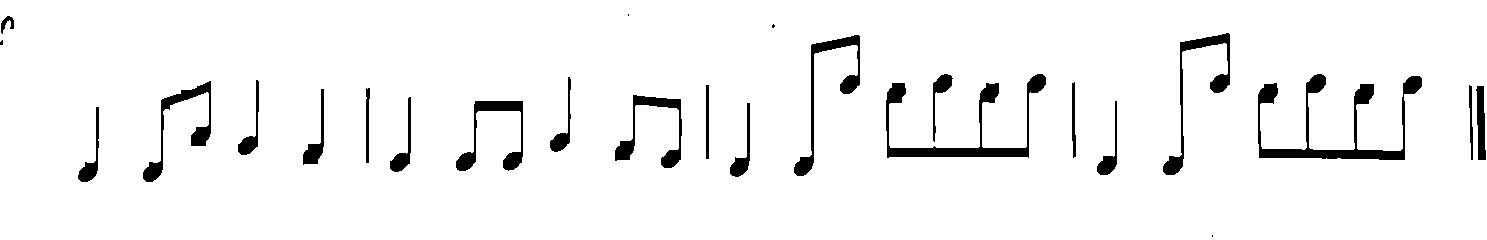

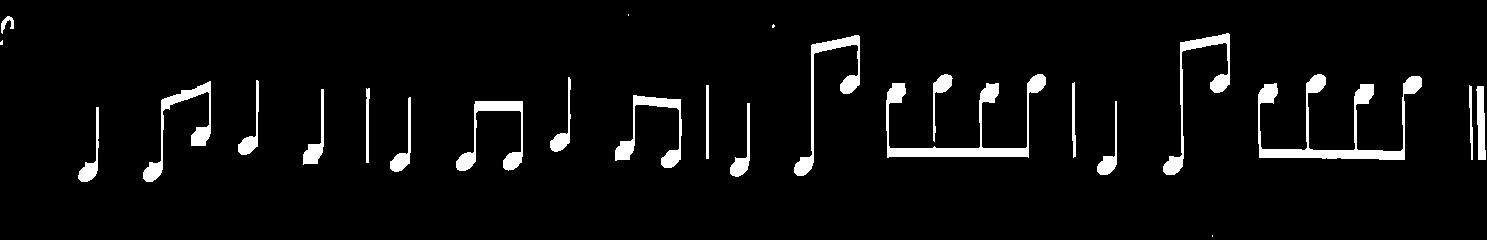

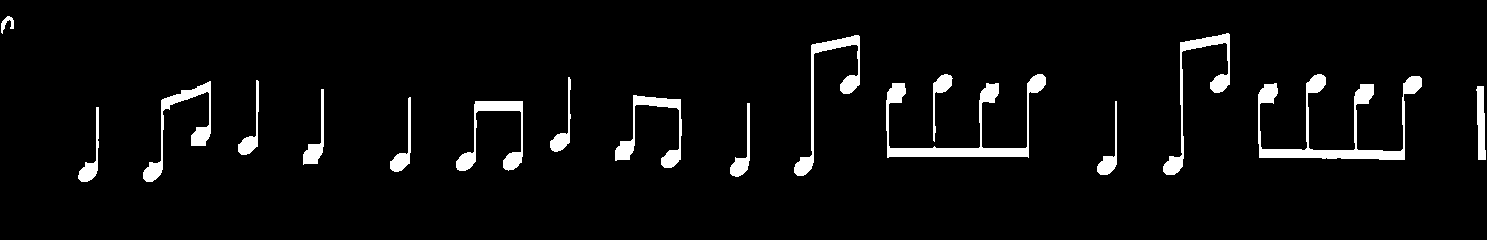

DETECTA BLANCAS
1


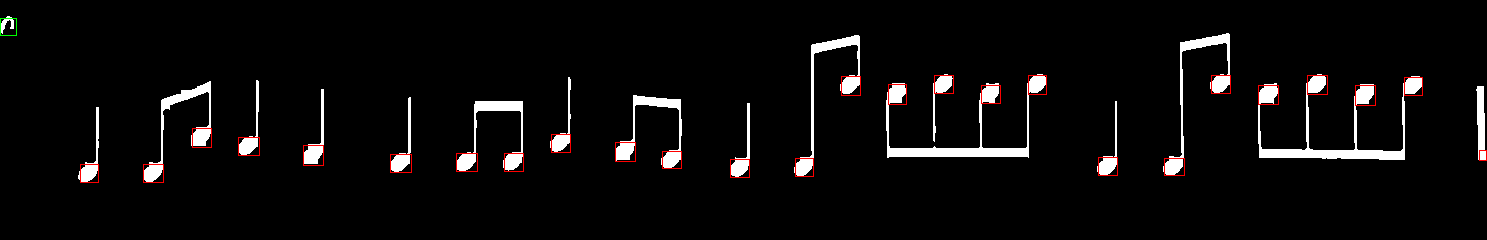

27
(0, 40, 5, 3, 'puntillo')
(366, 88, 75, 4, 'compas')
(628, 14, 2, 1, 'puntillo')
(706, 85, 74, 3, 'compas')
(772, 24, 4, 3, 'puntillo')
(1072, 82, 76, 4, 'compas')
(1212, 235, 2, 1, 'puntillo')
(1469, 85, 75, 4, 'compas')
[(0, 18, 16, 17), 41, 'Redonda', 'F']
[(80, 164, 18, 18), 29, 'Negra', 'D']
[(143, 164, 20, 18), 36, 'Corchea', 'D']
[(192, 128, 19, 19), 36, 'Corchea', 'G']
[(238, 137, 21, 18), 31, 'Negra', 'F']
[(303, 145, 20, 20), 33, 'Negra', 'F']
[(390, 154, 21, 18), 30, 'Negra', 'E']
[(456, 153, 21, 18), 34, 'Corchea', 'E']
[(504, 153, 19, 18), 34, 'Corchea', 'E']
[(551, 134, 19, 18), 32, 'Negra', 'G']
[(615, 142, 20, 19), 35, 'Corchea', 'F']
[(662, 151, 19, 17), 35, 'Corchea', 'F']
[(730, 159, 19, 18), 27, 'Negra', 'E']
[(795, 158, 18, 18), 37, 'Corchea', 'E']
[(841, 76, 19, 19), 37, 'Corchea', 'F']
[(888, 84, 18, 20), 39, 'Corchea', 'E']
[(934, 75, 19, 18), 26, 'Negra', 'F']
[(981, 85, 19, 18), 39, 'Corchea', 'E']
[(1028, 75, 18, 19), 39, 'Corchea', 'F']
[(1098, 157, 19, 1

In [28]:
#Array de notas para reproducción
Music = []

a = copy.deepcopy(imgO)
cv2_imshow(a)
imgs = []
adicional = 0
print(len(contours))
if(len(contours) > 5):
  x,y,w,hC = cv2.boundingRect(contours[4])
  x2,y2,w2,hC2 = cv2.boundingRect(contours[5])
  adicional = ((y2+hC2//2) - (y + hC//2))//2

print(adicional)

compo = 1
claveSol = [-1,-1,-1,-1]
compasI = [-1,-1,-1,-1]
for i in range(len(contours)//5):
  x,y,w,hC = cv2.boundingRect(contours[i*5])
  auxp = cv2.boundingRect(contours[i*5 + 1])
  midy1 = y + (hC//2)
  midy2 = auxp[1] + (auxp[3] // 2)
  x2,y2,w2,hC2 = cv2.boundingRect(contours[i*5+4])
  yini = y+(hC//2)  -adicional
  hmax = 0 # ALTURA MAXIMA DE LAS LINEAS DEL PENTAGRAMA
  for j in range(i*5,i*5 + 5):
    xt,yt,wt,hCt = cv2.boundingRect(contours[j])
    hmax = max(hmax,hCt)

  h = (y2+hC2//2) - (y + hC//2) + 2*adicional #ALTURA TOTAL DE LA IMAGEN EXTRAIDA
  hori = (y2+hC2//2) - (y + hC//2) #ALTURA DEL PENTAGRAMA
  espacio = int(hori/4) # ESPACIO ENTRE DOS LINEAS
  posCsolX, posCsolY, w3,hC3 = cv2.boundingRect(contours[i*5+3]) #UBICACION DE LA CLAVE DE SOL
  posCfaX, posCfaY, w3,hC3 = cv2.boundingRect(contours[i*5+1]) # UBICACION DE LA CLAVE DE FA
  imgs.append(a[yini:yini+h,x:x+w])
  imgs[i] = cv2.bitwise_not(imgs[i])
  posInicio = posCsolY + hC3//2 - yini + int(espacio/4) #Punto de partida para hallar las notas
  espaciop = midy2 - midy1
  espacioE = espacio//4
  print("ESPACIOS:", espacio, espaciop, espacioE)

  

  plt.rcParams['figure.figsize'] = [100, 50]
  #print(mTemp(imgs[i],csol, hori+ int(hori*0.85),0.7))
  #print(mTemp(imgs[i],sharp, (hori+ int(hori*0.85))//3,0.5))
  #print("PREV")
  cv2_imshow(imgs[i])
 
  ### RELLENAR LOS ESPACIOS QUE DEJARON LAS LINEAS
  if BORRADOS == False:
    imgs[i] = cv2.bitwise_not(imgs[i])
    #kerneltest
    #kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(hmax+2,hmax+2))

    kernel = np.ones((hmax+2,1),np.uint8)
    f = cv2.morphologyEx(imgs[i], cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((2,hmax//2),np.uint8)
    f = cv2.morphologyEx(f, cv2.MORPH_CLOSE, kernel,iterations=2)
    #f = cv2.morphologyEx(f, cv2.MORPH_CLOSE, kernel)

    imgs[i] = f
    imgs[i] = cv2.bitwise_not(imgs[i])
    print(hmax)
    
    cv2_imshow(imgs[i])

  print(espacio)
  print(imgs[i].shape)
  
  ## DETECTAR CLAVE DE SOL Y ARMADURAS 
  for e in csoles:
    ar = mTemp2(imgs[i],e, int(espacio*6.5),0.35)
  print(ar)
  #break
  #for e in sharps:
    #print(mTemp(imgs[i],e, espacio*2,0.47))
  print("CSOL")
  print(claveSol)
  at = mTemp(imgs[i],compas44,espacio*4,0.47)
  if(at[0] != -1):
    compasI = at
  at = mTemp(imgs[i],compas34, espacio*4,0.47)
  if(at[0] != -1):
    compasI = at
  at = mTemp(imgs[i],compas42, espacio*4,0.47)
  if(at[0] != -1):
    compasI = at
  xC,yC,hC,wC = compasI
  print(compasI)
  at = mTemp(imgs[i],aperturaRep, espacio*5,0.60)
  
  at = mTemp(imgs[i],cierreRep, espacio*5,0.60)


  #print("HOLA")
  #cv2_imshow(imgs[i][yC:yC+hC,xC:xC+wC])

  cv2_imshow(imgs[i])
  imgs[i] = cv2.bitwise_not(imgs[i])

  #AHORA EMPIEZA LO HORRIBLE

  '''
  #Comentar para que no detecte blancas
  imgs[i] = cv2.bitwise_not(imgs[i])
  kernel = np.ones((2,espacio),np.uint8)
  imgs[i]  = cv2.morphologyEx(imgs[i], cv2.MORPH_CLOSE, kernel)
  #cv2_imshow(imgs[i])
  #
  '''

  ## DETECCION DE CONTORNOS

  #imgs[i] = cv2.blur(imgs[i], (2,2))
  #ret,imgs[i] = cv2.threshold(imgs[i],190,255,cv2.THRESH_BINARY)
  cv2_imshow(imgs[i])
  contoursT, _ = cv2.findContours(imgs[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  actT = cv2.cvtColor(imgs[i],cv2.COLOR_GRAY2RGB)
  #cv2.drawContours(actT, contoursT, -1, (0,255,0), 1)
  Ts = []
  #print(len(contoursT))

  ## DETECCION DE SIMBOLOS

  contoursT.sort(key=lambda x:cv2.boundingRect(x)[2]*cv2.boundingRect(x)[3])
  
  simbolos = []
  

  NotasF = []
  for contour in contoursT:
    x,y,w,h = cv2.boundingRect(contour)
    #print(w*h)
    #if(h >= (hori+ int(hori*0.85)//2)):
    #print("MICHIS")
  
    #cv2_imshow(imgs[i][y:y+h,x:x+w])
    #continue

    #VERDADERA DETECCION DE SIMBOLOS
    #PALITO
    if(h >= 4*espacio and w <= espacio//2):
      #print("COMPAS")
      #cv2_imshow(imgs[i][y-10:y+h,x-10:x+w])
      imgs[i][y:y+h,x:x+w] = 0
      simbolos.append((x,y,h,w,'compas'))
      continue

    if(h <= espacio and w <= espacio/1.5):
      #print("PUNTILLO")
      #cv2_imshow(imgs[i][y:y+h,x:x+w])
      imgs[i][y:y+h,x:x+w] = 0
      simbolos.append((x,y,h,w,'puntillo'))
      continue

     # MICHI
    if(h >= espacio+10 and h <= espacio*3.5 ):
      
      r = 100
      for elem in sharps:
        r = min(r,comp2(imgs[i][y:y+h,x:x+w],elem, 2*espacio + espacio//2,mos = True))  
      if(r <= 0.21):
        print("Sharp")
        cv2_imshow(imgs[i][y:y+h,x:x+w])
        imgs[i][y:y+h,x:x+w] = 0
        simbolos.append((x,y,h,w, 'michi'))
        continue

      # NATURAL
      r = 100
      for elem in naturals:
        r = min(r,comp2(imgs[i][y:y+h,x:x+w],elem, 2*espacio + espacio//2,mos = True,tipo = 2)) 
      if(r <= 0.9):
        print("NATURAL")
        cv2_imshow(imgs[i][y:y+h,x:x+w])
        imgs[i][y:y+h,x:x+w] = 0
        simbolos.append((x,y,h,w, 'natural'))
        continue

      # QREST
      r = 100
      for elem in rests:
        #cv2_imshow(elem)
        r = min(r,comp2(imgs[i][y:y+h,x:x+w],elem, 2*espacio + espacio//2,mos = True,tipo = 3)) 
      if(r <= 0.3):
        print("QREST")
        cv2_imshow(imgs[i][y:y+h,x:x+w])
        imgs[i][y:y+h,x:x+w] = 0
        simbolos.append((x,y,h,w, 'qrest'))
        continue

      #BEMOLES
      r = 100
      for elem in bemoles:
        r = min(r,comp2(imgs[i][y:y+h,x:x+w],elem, 2*espacio + espacio//2,mos = True,tipo = 3)) 
      if(r <=0.5):
        print("BEMol")
        cv2_imshow(imgs[i][y:y+h,x:x+w])
        imgs[i][y:y+h,x:x+w] = 0
        simbolos.append((x,y,h,w, 'bemol'))
        continue


    '''
    if(h >= ( hori+ int(hori*0.85))//2): # CSOL
      r = 100
      for elem in csoles:
        r = min(r,comp2(imgs[i][y:y+h,x:x+w],elem, hori+ int(hori*0.85)))
      if(r <= 0.9):
        print("CSOL")
        cv2_imshow(imgs[i][y:y+h,x:x+w])
        imgs[i][y:y+h,x:x+w] = 0
        continue
    
    


    

    if(h >= espacio and h <= 2*espacio + espacio//2): # BEMOL
      r = 100
      for elem in bemoles:
        r = min(r,comp2(imgs[i][y:y+h,x:x+w],elem, (hori+ int(hori*0.85))//3)  )
      if(r <= 0.6):
        print("BEMol")
        cv2_imshow(imgs[i][y:y+h,x:x+w])
        imgs[i][y:y+h,x:x+w] = 0
        continue

    '''
    if(h >= espacio):
      Ts.append((x,y,w,h))


  #BUSCAR NOTAS
  Ts.sort(key=lambda x:x[2]*x[3])
  ## WIDTH HEIGHT
  cv2_imshow(imgs[i])
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(int(espacio*0.75),int(espacio*0.50))) # CHIQUITO
  kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(int(espacio*0.75),int(espacio*0.75)))  #GRANDE

  prueba = copy.deepcopy(imgs[i])
  prueba2 = cv2.cvtColor(imgs[i], cv2.COLOR_GRAY2BGR)

  
  for reg in Ts:
    x,y,w,h = reg
    act = imgs[i][y:y+h,x:x+w]
    
    if(h < espacio or w < espacio//2):
      continue

    nm = cv2.erode(act,kernel)
    
    prueba[y:y+h,x:x+w] = nm 
    nm = cv2.dilate(nm,kernel)

    act = nm
    #PRIMERA PASADA
    notasAct = []
    contoursN, _ = cv2.findContours(nm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contoursN:
      xN,yN,wN,hN = cv2.boundingRect(contour)
      notasAct.append((xN,yN,wN,hN))
    
    notasAct.sort(key=lambda x:x[0])
    notasF = []

    for nota in notasAct:
      xN,yN,wN,hN = nota
      #print(xN,yN,wN,hN)
      if(hN >= espacio/4.5 and wN <= 2*espacio and h >= espacio*1.5):
        notasF.append((x+xN,y+yN,wN,hN))
      else:
        imgs[i][y+yN:y+yN+hN,x+xN:x+xN+wN] = 0

    #SEGUNDA PASADA
    act = imgs[i][y:y+h,x:x+w]
    #cv2_imshow(act)
    nm = cv2.erode(act,kernel2)
    
 
    nm = cv2.dilate(nm,kernel2)

    notasAct = []
    contoursN, _ = cv2.findContours(nm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contoursN:
      xN,yN,wN,hN = cv2.boundingRect(contour)
      notasAct.append((xN,yN,wN,hN))

    notasAct.sort(key=lambda x:x[0])
    notasF = []
    #print(len(notasAct))
    dr = False
    #REVISAR SI ES CORCHEA
    corcheaa = False
    #cv2_imshow(act)
    if(w <= espacio*2 and len(notasAct) ==  2):
      corcheaa = True
    notasAct.sort(key=lambda x:x[2]*x[3])
    notasAct.reverse()
    for nota in notasAct:
      xN,yN,wN,hN = nota
      if(hN >= espacio//5 and wN <= 3*espacio and h >= espacio*2):
        notasF.append((x+xN,y+yN,wN,hN))
        if(corcheaa == False):
          cv2.rectangle(prueba2,(x+xN, y+yN), (x+xN +wN, y+yN + hN), (0,0,255),1)
        else:
          cv2.rectangle(prueba2,(x+xN, y+yN), (x+xN +wN, y+yN + hN), (255,255,0),1)
          dr = True
          break

        dr = True


    tipoN = "Negra"
    if(corcheaa or len(notasF) > 1):
      tipoN = "Corchea"

    if(len(notasF) > 0):
      for ns in notasF:
        NotasF.append([ns,compo,tipoN])
      compo+= 1
    if(dr):
      imgs[i][y:y+h,x:x+w] = 0


  #DETECCION DE BLANCAS Y REDONDAS
  print("DETECTA BLANCAS")
  
  kernel = np.ones((2,espacio*2),np.uint8)
  imgs[i] = cv2.morphologyEx(imgs[i], cv2.MORPH_CLOSE, kernel)
  kernel = np.ones((espacio*2,2),np.uint8)
  imgs[i] = cv2.morphologyEx(imgs[i], cv2.MORPH_CLOSE, kernel)

  contoursT, _ = cv2.findContours(imgs[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  actT = cv2.cvtColor(imgs[i],cv2.COLOR_GRAY2RGB)

  Ts = []

  for contour in contoursT:
    x,y,w,h = cv2.boundingRect(contour)
    if(h >= espacio):
      Ts.append((x,y,w,h))

  Ts.sort(key=lambda x:x[0])
  #WIDTH HEIGHT
  kernel = kernel2
  #kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(espacio,espacio//2))


  
  for reg in Ts:
    x,y,w,h = reg
    act = imgs[i][y:y+h,x:x+w]

    nm = cv2.erode(act,kernel)   
    prueba[y:y+h,x:x+w] = nm 
    nm = cv2.dilate(nm,kernel)


    notasAct = []
    contoursN, _ = cv2.findContours(nm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contoursN:
      xN,yN,wN,hN = cv2.boundingRect(contour)
      notasAct.append((xN,yN,wN,hN))
    
    notasAct.sort(key=lambda x:x[0])
    notasF = []
    print(len(notasAct))
    tipoN = "Blanca"
    for nota in notasAct:
      xN,yN,wN,hN = nota
      if(h <= espacio*1.5):
        tipoN = "Redonda"
      notasF.append((x+xN,y+yN,wN,hN))

      cv2.rectangle(prueba2,(x+xN, y+yN), (x+xN +wN, y+yN + hN), (0,255,0),1)



    #print(len(notasF))
    #cv2_imshow(act)
    
    if(len(notasF) == 1):
      NotasF.append([notasF[0],compo,tipoN])


  #cv2_imshow(prueba)

  '''
  #DIBUJAR RECTANGULOS
  xtt,ytt,wtt,htt = cv2.boundingRect(contours[i*5])
  prueba3 = copy.deepcopy(prueba2)
  #cv2.line(prueba3,(0, ytt-yini), (0 +prueba2.shape[0]-1000,ytt-yini), (155,255,10),10)
  for g in range(5):
     xtta,ytta,wtta,htta = cv2.boundingRect(contours[i*5+g])
     cv2.line(prueba3,(0, ytta-yini), (0 +prueba2.shape[1],ytta-yini), (255,255,255),1)
  for i in range(hori//espacioE):
    print(0, ytt+i*espacioE,0 +prueba2.shape[0]-10, ytt+i*espacioE + htt)
    cv2.rectangle(prueba3,(0, ytt-yini+i*espacioE), (0 + prueba2.shape[1]-10, ytt-yini+i*espacioE + htt), (130,130,1))

 
  #cv2_imshow(imgs[i])
  '''
  cv2_imshow(prueba2)
  print(len(NotasF))
  #print(NotasF)
  notasRes = []
  base = 4 
  for ia in range(len(NotasF)): 
    #for e in nts:
    x,y,w,h = NotasF[ia][0]
    #print(posInicio)
    #print(x,y,w,h)
    #print(y,posInicio)
    centro = y + h//2
    diferencia = posInicio - centro
    #print("DIF",diferencia)
    n = diferencia//(espacioE*2)
    '''
    n = diferencia // espacioE
    cell = n % 6
    n = diferencia // (espacioE * 3)
    n += int(cell > 1)
    notasRes.append(n)
    #print(notasK[(n+base)%7], end = " ")
    '''
    if n > 2: n -= 1
    elif n < -1: n += 1
    NotasF[ia].append(notasK[(n+base)%7])
      
  NotasF.sort(key=lambda x:x[0][0])
  simbolos.sort(key = lambda x: x[0])

  '''
  nota[0]: (x, y, h, w)
  nota[1]: identificador, no me importa
  nota[2]: duracion
  nota[3]: nota

  simb = (x, y, h, w, duracion)
  '''

  ## Falta considerar armadura!
  def get_final_notes(notes, symbols):
    N = len(notes)
    M = len(symbols)
    symbols.append((1000000, 0, 0, 0, 'F'))
    i, j = 0, 0
    ans = []
    lasts = None
    lastn = None
    while i < N:
      curn = notes[i]
      curs = symbols[j]
      if curs[0] <= curn[0][0]: #process symbol first
        j += 1
        if curs[4] == 'compas': continue
        if curs[4] == 'puntillo':
          if lastn != None:
            miny = lastn[0][1]
            maxy = lastn[0][1] + lastn[0][2]
            disx = curs[0] - lastn[0][0]
            if miny-15 < curs[1] and curs[1] < maxy and disx < 2 * espacio:
              ans[-1][2] += 'Puntillo'
        lasts = curs
      else: #process note 
        if lasts != None and lasts[4] != 'compas' and lasts[4] != 'puntillo':
          if lasts[4] == 'michi': 
            curn[3] += '#'
            lasts = None
          elif lasts[4] == 'bemol':
            curn[3] += 'b'
            lasts = None
        lastn = curn
        ans.append(curn)
        i += 1
    while j < M:
      if symbols[j][4] == 'puntillo':
        if lastn != None:
          curs = symbols[j]
          miny = lastn[0][1] - 15
          maxy = lastn[0][1] + lastn[0][2]
          disx = curs[0] - lastn[0][0]
          if miny < curs[1] and curs[1] < maxy and disx < 2 * espacio:
            ans[-1][2] += 'Puntillo'
        break
      j += 1
    return ans
          


  for s in simbolos:
    print(s)
  for nts in NotasF:
    print(nts)
  
  print('\n\n Finales \n')
  fff = get_final_notes(NotasF, simbolos)

  Music.append(fff)

  for aaaa in fff:
    print(aaaa)
    #print(nts[2],nts[3])
  
  #plt.subplot(121),plt.imshow(kernel,cmap = 'gray')
  #plt.show()
  #break
  #for n in notasRes:
    #print(notasK[(n+base)%7])
 
  #print(notas)

#Reproducción

In [ ]:

for i in Music:
  for j in i:
    if i == Music[len(Music)-1] and j == i[len(i)-1]:
      print('["'+j[3]+'",','"'+j[2]+'"]')
    else:
      print('["'+j[3]+'",','"'+j[2]+'"],')


["E", "Corchea"],
["E", "Corchea"],
["E", "Negra"],
["E", "Corchea"],
["A", "Corchea"],
["A", "Corchea"],
["A", "Corchea"],
["A", "Corchea"],
["G", "Corchea"],
["G", "Corchea"],
["G", "Corchea"],
["G", "Corchea"],
["C", "Corchea"],
["C", "Corchea"],
["C", "Corchea"],
["C", "Corchea"],
["D", "Corchea"],
["D", "Corchea"],
["D", "Corchea"],
["D", "Corchea"],
["D", "Corchea"],
["D", "Corchea"],
["E", "Corchea"],
["E", "Corchea"],
["E", "Corchea"],
["E", "Corchea"],
["G", "Corchea"],
["F", "Negra"],
["F", "Corchea"],
["C", "Corchea"],
["D", "Negra"],
["D", "Corchea"],
["A", "Corchea"],
["G", "Negra"],
["F", "Negra"],
["E", "Negra"],
["E", "Corchea"],
["E", "Corchea"],
["G", "Negra"],
["F", "Corchea"],
["F", "Corchea"],
["D", "Negra"],
["D", "Corchea"],
["F", "Corchea"],
["E", "Corchea"],
["F", "Negra"],
["E", "Corchea"],
["F", "Corchea"],
["E", "Negra"],
["E", "Corchea"],
["F", "Corchea"],
["E", "Corchea"],
["F", "Corchea"],
["E", "Corchea"],
["A", "Blanca"],
["D", "Negra"],
["D", "Corchea"